# Proyecto Integrador

## Servicio de calidad aumentada por IA

**Equipo 3:**

- Jorge Chávez Badillo A01749448

- Andrea Fernanda Molina Blandón A00827133

- Ismael Alexander Carvajal González A01793925

# Resumen ejecutivo (alcance ajustado)

Tras una reunión con asesores de IBM, se reduce el alcance del Proyecto Integrador para enfocarlo en el proyecto más relevante de Castor (metalurgia para construcción). En esta entrega solo se trabaja en Regression Test Selection (RTS) y, si el tiempo lo permite, en un asistente de Pull Request (PR) con IBM Watson. El resto de componentes queda como trabajo futuro.

## Nombre del proyecto

Servicio de calidad aumentada por IA

## Contexto de la empresa

Castor (Medellín, Colombia) desarrolla software y UX/UI. Para este PI se centra exclusivamente en metalurgia para construcción, por ser el proyecto de mayor impacto.

## Alcance actual (máximo entregable de esta entrega)

Disparo por PR (simulado): La creación de un PR activa el pipeline CI/CD y registra metadatos (Jira/Azure DevOps, simulado).

Integración con IBM (por definir servicios): El pipeline envía datos del cambio de código a IBM Cloud para su procesamiento.

Modelo de RTS: Un modelo selecciona el subconjunto óptimo de casos de prueba a ejecutar a partir de archivos modificados y características del cambio.

Asistente de PR (opcional, si alcanza): Agente basado en IBM Watson (p.ej., Discovery + RAG) para resúmenes/sugerencias sobre el PR usando documentación interna.

## Fuera de alcance en esta entrega (quedará como futuro/simulado)

Ejecución real + retroalimentación: resultados, detección de flaky tests y reentrenamiento.

Publicación consolidada en el PR (análisis estático, riesgo de defectos, resultados y sugerencias) y actualización en Jira/Azure DevOps.

Dashboard DORA para monitoreo estratégico.

Modelo de evaluación de riesgo de cambios (queda para fase posterior).

# Avance 1: EDA de Casos de Prueba (Cotizaciones/Pedidos)

**Fecha:** 28-09-2025

Metricas en este Notebook: univariante (histos/boxplots), categóricas (barras), bi/multivariante (correlación numérica + crosstab + Cramér’s V), preprocesamiento (faltantes, outliers, cardinalidad), selección de características (2.1) para recuperación (TF-IDF + SVD con **fix robusto**), y export limpio.


## 0) Configuración y carga de datos

In [1]:
from __future__ import annotations
import re, json, sys, time, platform, hashlib, warnings
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
plt.rcParams.update({"figure.figsize": (8,5)})

@dataclass
class Config:
    # Paths
    RAW_TESTS: Path = Path("../data/raw/TestCases.csv")
    RAW_CHANGED: Path = Path("../data/raw/ChangedFiles.csv")
    RAW_META: Path = Path("../data/raw/PipelineMeta.csv")
    OUT_DIR: Path = Path("../data/processed")
    RUN_DIR: Path = Path("../run_artifacts")
    # Behavior
    MAKE_PLOTS: bool = True
    USE_SVD: bool = False           # Desactivado: RTS no lo requiere (reduce tiempo/memoria)
    TOP_FRACTION: float = 0.15      # % de tests a seleccionar por PR
    TFIDF_MAX_FEATURES: int = 6000  # Dim TF-IDF
    LINES_NORM: int = 300           # Normalizador de tamaño de cambio
    # Pesos del score RTS
    W_SIM: float = 0.6
    W_MODULE: float = 0.2
    W_RISK: float = 0.1
    W_SIZE: float = 0.1

CFG = Config()
assert CFG.RAW_TESTS.exists(), f"No se encontró {CFG.RAW_TESTS}"
assert CFG.RAW_CHANGED.exists(), f"No se encontró {CFG.RAW_CHANGED}"
assert CFG.RAW_META.exists(), f"No se encontró {CFG.RAW_META}"
CFG.OUT_DIR.mkdir(parents=True, exist_ok=True)
CFG.RUN_DIR.mkdir(parents=True, exist_ok=True)


## 1) Utilidades: hashing, casting, gráficos

In [3]:
def sha256(path: Path) -> str | None:
    if not path.exists(): return None
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

def to_numeric(series: pd.Series) -> pd.Series:
    # vectorizado: cambia coma decimal y convierte; errores -> NaN
    return pd.to_numeric(series.astype(str).str.replace(",", ".", regex=False), errors="coerce")

def bar(series: pd.Series, title: str, xlabel: str):
    ax = series.plot(kind="bar")
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel("conteo")
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

def hist(series: pd.Series, title: str, xlabel: str, bins=30):
    series.plot(kind="hist", bins=bins, alpha=0.85)
    plt.title(title); plt.xlabel(xlabel); plt.tight_layout(); plt.show()


## 2) Carga y normalización (vectorizado)

In [4]:
ALIAS: Dict[str, List[str]] = {
    "case_id": ["case_id","id","Id","ID","codigo","código","id caso","id_cp","id cp"],
    "title": ["title","titulo","título","nombre cp","nombre_cp","nombre del caso","nombre","NOMBRE CP","NOMBRE"],
    "preconditions": ["preconditions","precondiciones","pre-condiciones","precondición","precondicion","precondiciones cp","Precondición"],
    "steps": ["steps","pasos","procedimiento","instrucciones","PASOS"],
    "expected_result": ["expected_result","resultado_esperado","resultado esperado","RESULTADO ESPERADO"],
    "obtained_result": ["obtained_result","resultado_obtenido","resultado obtenido","RESULTADO OBTENIDO"],
    "observations": ["observations","observaciones","notas","OBSERVACIONES"],
    "exec_count": ["# ejec","num_ejec","num ejec","ejecuciones","# ejecuciones","# EJEC","#EJEC"],
    "test_status": ["estado de la prueba","estado_prueba","resultado","estado","TEST STATUS","Estado de la prueba"],
    "feature_name": ["nombre de la funcionalidad","funcionalidad","feature","Nombre de la funcionalidad"],
    "sprint": ["sprint","iteracion","iteración","SPRINT"],
    "created_at": ["fecha de creación","fecha_creacion","creado","Fecha de creación"],
    "module": ["module","módulo","modulo","area","área","component","componente","modulo funcional"],
    "type": ["type","tipo","categoria","category","tipo de prueba","tipo prueba","clase de prueba"],
    "priority": ["priority","prioridad","severity","severidad"],
    "estimated_duration_min": ["estimated_duration_min","duracion_min","duración_min","duration","duracion","duración"],
}

TEXT_COLS = ["title","preconditions","steps","expected_result","obtained_result","observations"]

def rename_by_alias(df: pd.DataFrame, alias: Dict[str, List[str]]) -> pd.DataFrame:
    lower_map = {c.lower(): c for c in df.columns}
    rename_map = {}
    for std, options in alias.items():
        for opt in options:
            col = lower_map.get(opt.lower())
            if col:
                rename_map[col] = std; break
    return df.rename(columns=rename_map)

def load_and_clean_tests(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = rename_by_alias(df, ALIAS)

    # Texto: fillna y trim vectorizado
    for c in [x for x in TEXT_COLS + ["feature_name"] if x in df.columns]:
        df[c] = df[c].fillna("").astype(str).str.strip()

    # Categóricas: trim (y opcionalmente convertir a 'category' para memoria)
    for c in [x for x in ["module","type","priority","test_status","sprint"] if x in df.columns]:
        df[c] = df[c].astype(str).str.strip()

    # Numéricas
    if "exec_count" in df.columns:
        df["exec_count"] = to_numeric(df["exec_count"]).astype("float")
    if "estimated_duration_min" in df.columns:
        df["estimated_duration_min"] = to_numeric(df["estimated_duration_min"]).astype("float")

    # Duplicados exactos (rápido, estable)
    df = df.drop_duplicates()

    # Longitudes (vectorizado)
    for c in [x for x in TEXT_COLS if x in df.columns]:
        df[f"{c}_len"] = df[c].str.len()

    return df

df = load_and_clean_tests(CFG.RAW_TESTS)
print("Shape:", df.shape)
display(df.head(4))

Shape: (288, 19)


,case_id,title,preconditions,steps,expected_result,obtained_result,observations,exec_count,test_status,feature_name,sprint,created_at,module,title_len,preconditions_len,steps_len,expected_result_len,obtained_result_len,observations_len
0,1-HU1-1,Visualización de la opción 'Cotización' en el ...,Haber accedido al 'Portal de Clientes',"1) Filtrar el cliente por RNC, nombre o Código...",La opción 'Cotización' aparece correctamente e...,La opción 'Cotización' aparece correctamente e...,,3.0,Ejecución exitosa,Ingresar al módulo de cotizaciones,1.0,2025-01-03,Cotizaciones,102,38,200,66,66,0
1,1-HU1-2,Redirección a la página de Cotizaciones al hac...,Haber accedido al 'Portal de Clientes' y carga...,1) Hacer clic en la opción 'Cotización' del me...,El usuario es redirigido correctamente a la pá...,El usuario es redirigido correctamente a la pá...,,3.0,Ejecución exitosa,Ingresar al módulo de cotizaciones,1.0,2025-01-03,Cotizaciones,69,75,59,67,67,0
2,1-HU1-3,Cargar la página de Cotizaciones en menos de 3...,Haber accedido al 'Portal de Clientes' y carga...,1) Hacer clic en la opción 'Cotización' del me...,La página de Cotizaciones carga correctamente ...,La página de Cotizaciones no carga correctamen...,La página se tarda en cargar,2.0,Falló en su ejecución,Ingresar al módulo de cotizaciones,1.0,2025-01-03,Cotizaciones,55,75,59,87,90,28
3,1-HU1-4,Contenido correcto en la página de Cotizacione...,Haber accedido al 'Portal de Clientes' y carga...,1) Hacer clic en la opción 'Cotización' del me...,El contenido de la página de Cotizaciones es v...,El contenido de la página de Cotizaciones es v...,,3.0,Ejecución exitosa,Ingresar al módulo de cotizaciones,1.0,2025-01-03,Cotizaciones,67,75,113,64,64,0


##  3) Status + módulo inferido (sin apply row-wise)

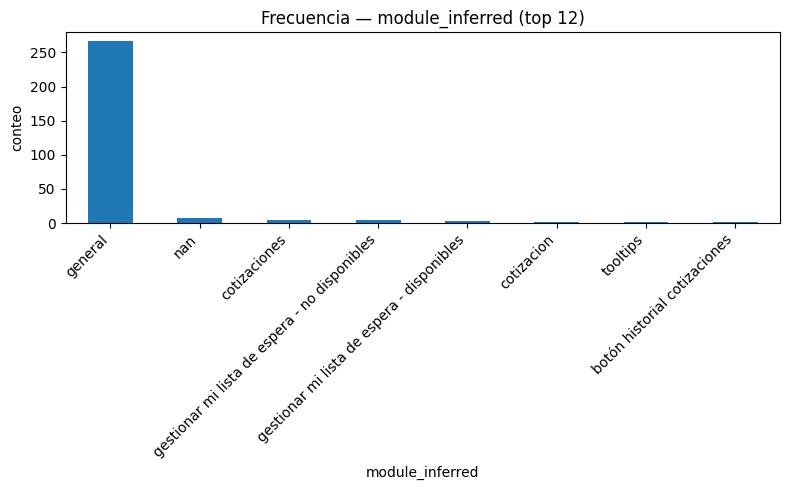

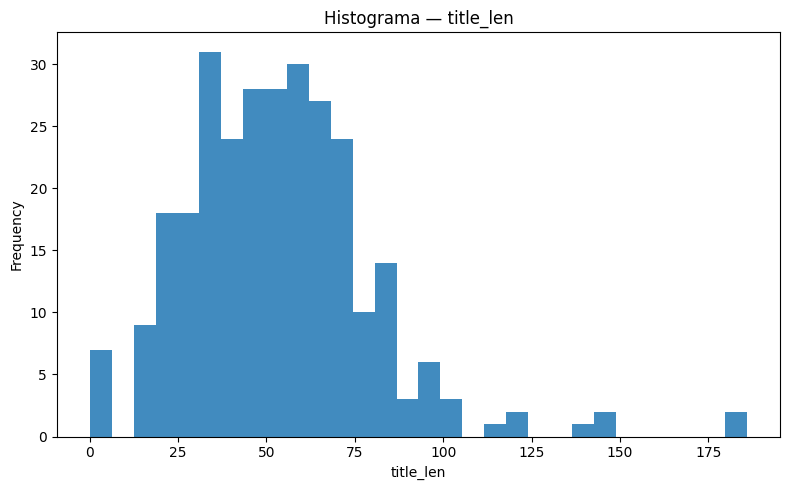

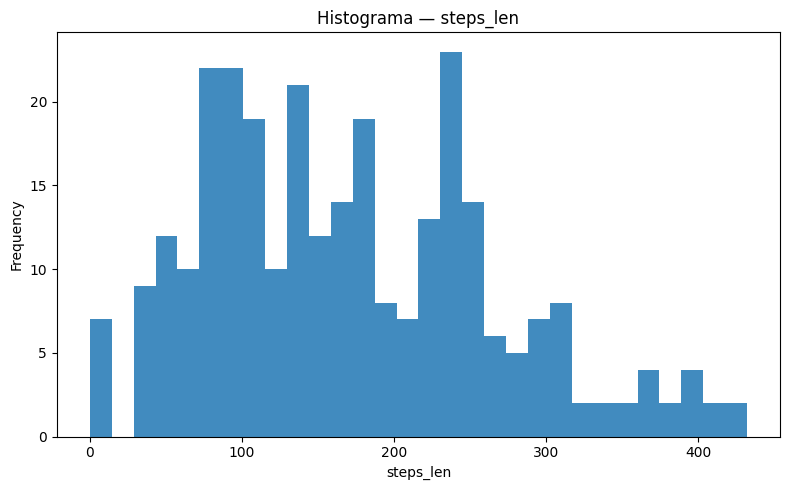

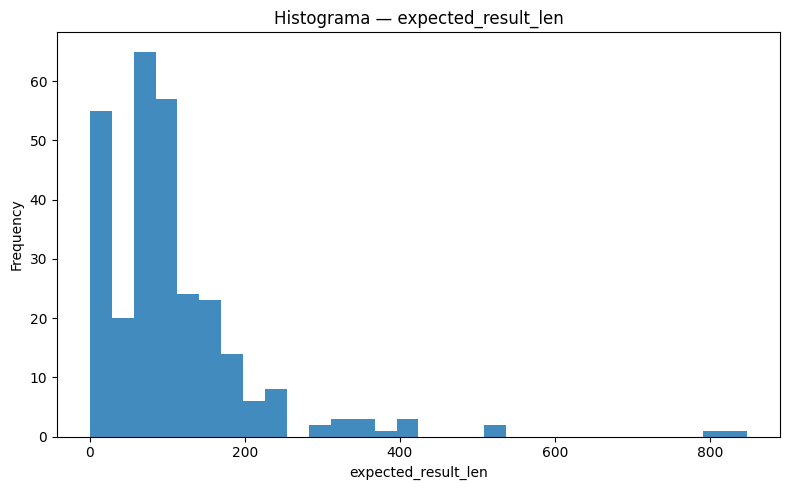

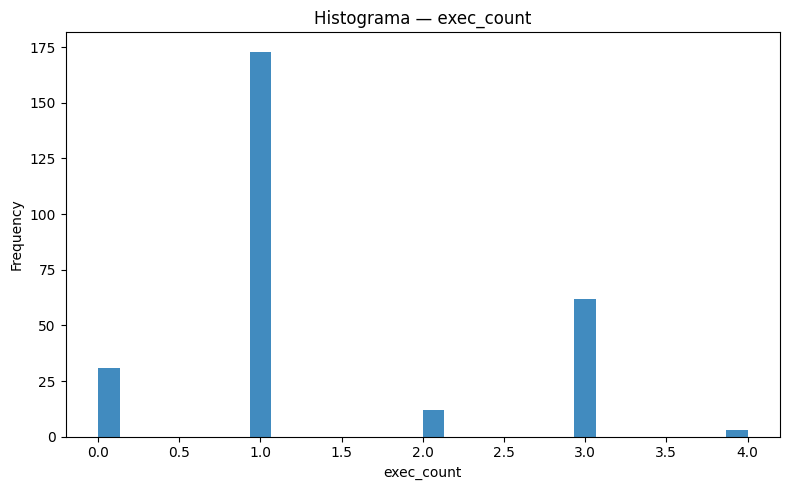

In [5]:
STATUS_MAP = {
    "ejecución exitosa":"pass","ejecucion exitosa":"pass","ok":"pass","exitoso":"pass","exitosamente":"pass",
    "falló en su ejecución":"fail","fallo en su ejecucion":"fail","falló":"fail","fail":"fail","no cumple":"fail",
    "no se ejecutó":"not_run","no se ejecuto":"not_run","pendiente":"not_run",
    "el componente no esta listo":"blocked","bloqueada":"blocked","bloqueado":"blocked"
}

def normalize_status_col(s: pd.Series) -> pd.Series:
    s = s.fillna("").astype(str).str.strip().str.lower()
    mapped = s.map(STATUS_MAP)

    mask_unset = mapped.isna()

    mapped.loc[mask_unset & s.str.contains(r"(exitosa|exitos|^ok$)", regex=True)] = "pass"
    mapped.loc[mask_unset & s.str.contains(r"(fall|error)", regex=True)]           = "fail"
    mapped.loc[mask_unset & s.str.contains(r"(no se ejec|pend)", regex=True)]     = "not_run"
    mapped.loc[mask_unset & s.str.contains(r"(bloque|no est[aá] listo)", regex=True)] = "blocked"

    return mapped


df["status_std"] = normalize_status_col(df["test_status"]) if "test_status" in df.columns else np.nan

def infer_module_fast(df: pd.DataFrame) -> pd.Series:
    # Texto agregado para heurística
    base = (
        df.get("module", "").astype(str).str.lower().str.strip() + " " +
        df.get("feature_name", "").astype(str).str.lower() + " " +
        df.get("title", "").astype(str).str.lower() + " " +
        df.get("steps", "").astype(str).str.lower()
    )
    conds = [
        base.str.contains("cotizacion|cotización|cotizaciones", regex=True),
        base.str.contains(r"\bpedido(s)?\b", regex=True),
        base.str.contains("precio(s)?", regex=True),
        base.str.contains("impuesto(s)?", regex=True),
        base.str.contains("cliente(s)?", regex=True),
    ]
    choices = ["cotizaciones","pedidos","precios","impuestos","clientes"]
    inferred = np.select(conds, choices, default="otros")
    # prioriza 'module' explícito si existe
    module_explicit = df.get("module")
    if module_explicit is not None:
        m = module_explicit.astype(str).str.lower().str.strip()
        inferred = np.where(m.ne(""), m, inferred)
    return pd.Series(inferred, index=df.index)

df["module_inferred"] = infer_module_fast(df)

# Gráficos mínimos útiles para RTS
if CFG.MAKE_PLOTS:
    bar(df["module_inferred"].value_counts().head(12), "Frecuencia — module_inferred (top 12)", "module_inferred")
    for c in [x for x in ["title_len","steps_len","expected_result_len","exec_count"] if x in df.columns]:
        hist(df[c].dropna(), f"Histograma — {c}", c, bins=30)


## 4) Outliers ligeros

In [6]:
if "estimated_duration_min" in df.columns:
    q01, q99 = df["estimated_duration_min"].quantile([0.01, 0.99])
    df["estimated_duration_min"] = df["estimated_duration_min"].clip(q01, q99)
    if df["estimated_duration_min"].skew() > 1:
        df["estimated_duration_min_log1p"] = np.log1p(df["estimated_duration_min"])


## 5) Texto completo (1 pasada)

In [7]:
for c in TEXT_COLS:
    if c not in df.columns: df[c] = ""
df["text_full"] = df[TEXT_COLS].astype(str).agg(" ".join, axis=1)

# Guardado básico de features limpias (útil para auditoría)
keep_cols = [
    "case_id","title","preconditions","steps","expected_result","obtained_result","observations",
    "feature_name","sprint","created_at",
    "module","module_inferred","type","priority","exec_count","test_status","status_std",
    "estimated_duration_min","estimated_duration_min_log1p",
    "title_len","steps_len","expected_result_len","obtained_result_len","preconditions_len","observations_len",
]
keep_cols = [c for c in keep_cols if c in df.columns]
df[keep_cols + ["text_full"]].to_csv(CFG.OUT_DIR / "TestCases_clean_features.csv", index=False)


## 6) Datos del PR (ChangedFiles + PipelineMeta) => documento por PR

In [8]:
cf = pd.read_csv(CFG.RAW_CHANGED)
pm = pd.read_csv(CFG.RAW_META)

for f in (cf, pm):
    for c in f.columns:
        if f[c].dtype == "O":
            f[c] = f[c].astype(str).str.strip()

def path_tokens(path: str) -> str:
    s = re.sub(r"[^a-zA-Z0-9_/.\-]", " ", str(path))
    parts = re.split(r"[/_.\-]+", s.lower())
    parts = [p for p in parts if p and len(p) > 1]
    return " ".join(parts)

pr_docs = (
    cf.assign(file_tokens=cf["file_path"].map(path_tokens))
      .groupby("pr_id")
      .agg(file_tokens=("file_tokens", " ".join),
           modules_str=("module", lambda s: " ".join(map(str, s))),
           lines_added=("lines_added","sum"),
           lines_deleted=("lines_deleted","sum"))
      .join(pm.set_index("pr_id")[["pr_title","pr_desc","severity_declared","has_db_migration","changed_files"]], how="left")
      .fillna({"pr_title":"","pr_desc":"","modules_str":"","file_tokens":""})
)

pr_docs["pr_text"] = pr_docs["pr_title"]+" "+pr_docs["pr_desc"]+" "+pr_docs["file_tokens"]+" "+pr_docs["modules_str"]
pr_docs["total_lines_changed"] = (pr_docs["lines_added"].fillna(0) + pr_docs["lines_deleted"].fillna(0)).astype(int)
display(pr_docs.head(4))


,file_tokens,modules_str,lines_added,lines_deleted,pr_title,pr_desc,severity_declared,has_db_migration,changed_files,pr_text,total_lines_changed
pr_id,,,,,,,,,,,
PR-1001,services precios taxes py api cotizaciones end...,cotizaciones cotizaciones cotizaciones,240,55,Ajuste cálculo de precios por IVA diferenciado,Se corrige el cálculo de impuestos para cotiza...,normal,no,3,Ajuste cálculo de precios por IVA diferenciado...,295
PR-1002,services pedidos validator py db migrations 20...,pedidos pedidos pedidos,115,38,Fix validación de clientes al crear pedido,Se agrega validación estricta y se crea índice...,critical,yes,3,Fix validación de clientes al crear pedido Se ...,153
PR-1003,ui clientes searchbar tsx services clientes re...,clientes clientes,45,17,Optimización de búsqueda de clientes,Se mejora la búsqueda por RNC y nombre y se re...,normal,no,2,Optimización de búsqueda de clientes Se mejora...,62


## 7) RTS core: Vectorización conjunta + score rápido (sin bucles)

[RTS] PR-1001: top 43/288 | umbral=0.1644 -> ..\data\processed\RTS_selected_PR-1001.csv
[RTS] PR-1002: top 43/288 | umbral=0.1693 -> ..\data\processed\RTS_selected_PR-1002.csv


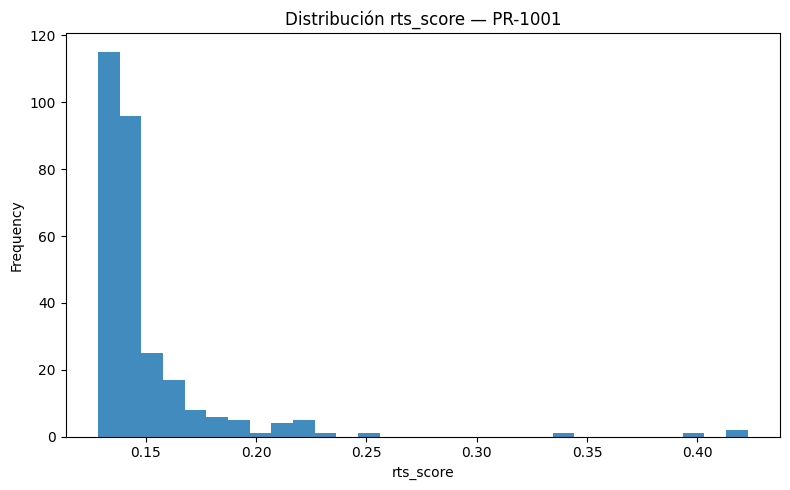

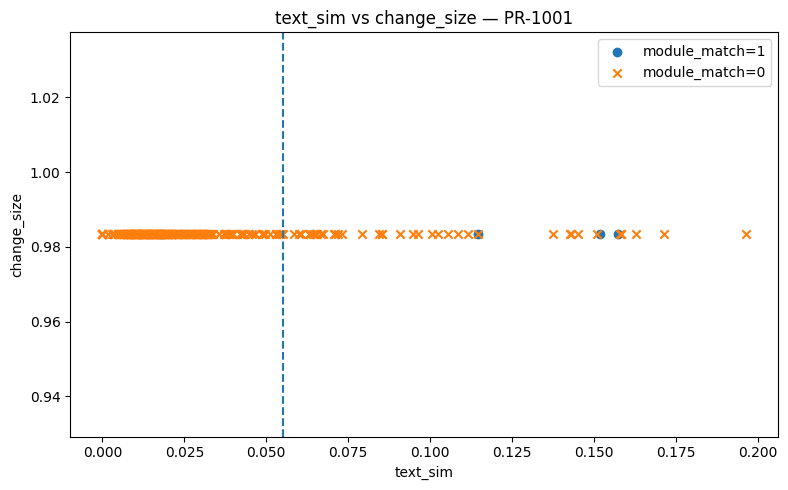

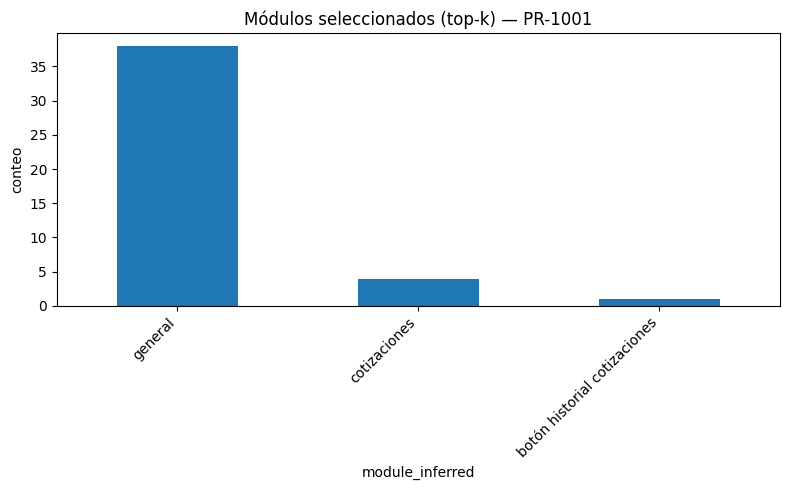

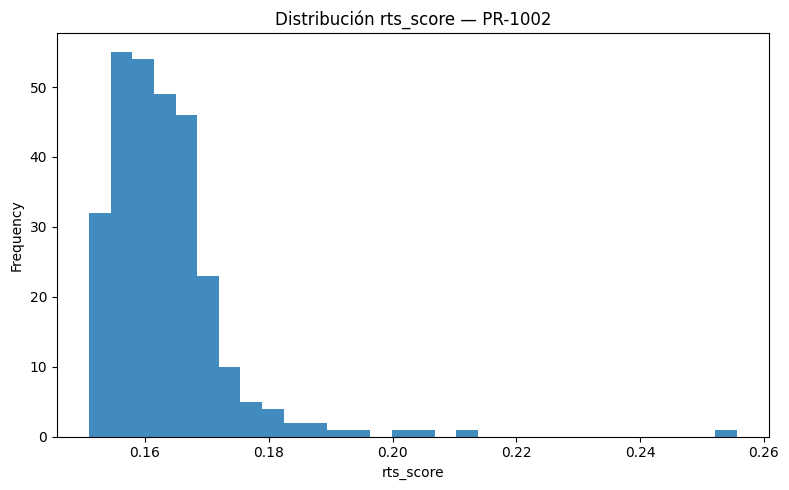

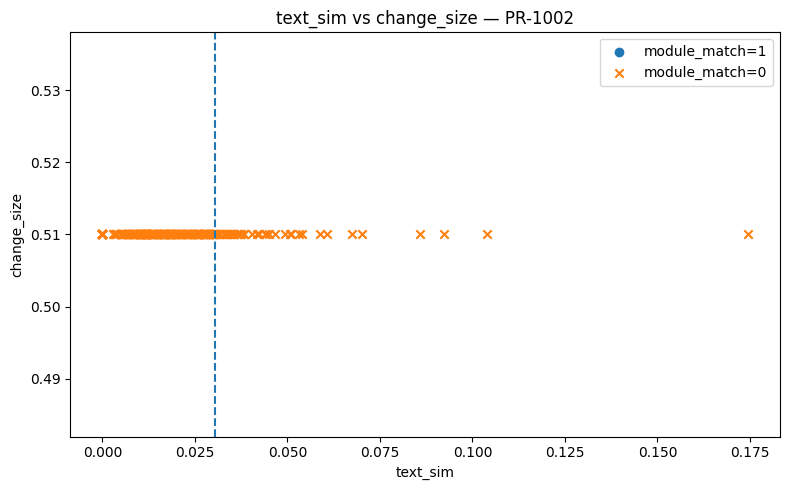

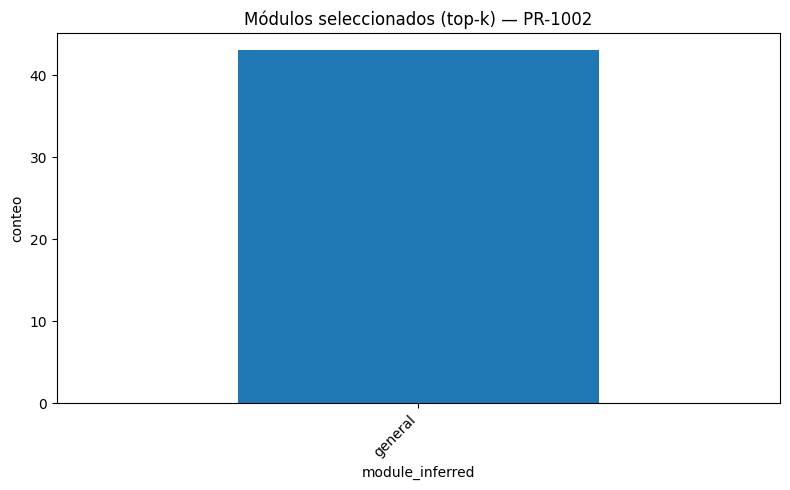

In [9]:
corpus_tests = df["text_full"].tolist()
corpus_prs = pr_docs["pr_text"].tolist()
vectorizer = TfidfVectorizer(max_features=CFG.TFIDF_MAX_FEATURES)
X = vectorizer.fit_transform(corpus_tests + corpus_prs)
X_tests = X[:len(corpus_tests)]
X_prs = X[len(corpus_tests):]

pr_index = {pid:i for i, pid in enumerate(pr_docs.index)}

def _severity_score(sev: str) -> float:
    sev = str(sev).lower()
    return {"critical":1.0,"high":0.7,"normal":0.3,"low":0.1}.get(sev, 0.3)

def rts_rank_for_pr(pr_id: str, top_frac: float = CFG.TOP_FRACTION) -> Tuple[pd.DataFrame, pd.DataFrame, float]:
    if pr_id not in pr_index:
        raise ValueError(f"pr_id '{pr_id}' no encontrado. Disponibles: {list(pr_index)[:5]} ...")
    j = pr_index[pr_id]
    y = X_prs[j]                            # vector PR
    sim = (X_tests @ y.T).toarray().ravel() # coseno (TF-IDF tiene L2 por defecto)

    # módulo_match vectorizado
    changed_mods = set(map(str.lower, cf.loc[cf["pr_id"]==pr_id, "module"].dropna().astype(str)))
    module_match = df["module_inferred"].str.lower().isin(changed_mods).astype(float).values

    # riesgo + tamaño normalizado
    row = pr_docs.loc[pr_id]
    risk = _severity_score(row.get("severity_declared","normal"))
    if str(row.get("has_db_migration","no")).lower() in {"yes","si","true","1"}:
        risk += 0.2
    risk = float(min(1.0, max(0.0, risk)))
    change_size = float(min(1.0, row.get("total_lines_changed", 0) / CFG.LINES_NORM))

    # score final (sin bucles)
    score = CFG.W_SIM*sim + CFG.W_MODULE*module_match + CFG.W_RISK*risk + CFG.W_SIZE*change_size

    full = df[["case_id","title","module_inferred"]].copy()
    full["text_sim"] = sim
    full["module_match"] = module_match
    full["risk"] = risk
    full["change_size"] = change_size
    full["rts_score"] = score
    full = full.sort_values("rts_score", ascending=False, kind="mergesort").reset_index(drop=True)
    full["rank"] = full.index + 1

    k = max(5, int(len(full)*top_frac))
    selected = full.head(k).copy()
    threshold = float(selected["rts_score"].min())
    out_path = CFG.OUT_DIR / f"RTS_selected_{pr_id}.csv"
    selected.to_csv(out_path, index=False)
    print(f"[RTS] {pr_id}: top {k}/{len(full)} | umbral={threshold:.4f} -> {out_path}")
    return selected, full, threshold

# Ejemplos
sel_1001, full_1001, thr_1001 = rts_rank_for_pr("PR-1001")
sel_1002, full_1002, thr_1002 = rts_rank_for_pr("PR-1002")

# Diagnósticos compactos
def plot_rts(pr_id: str, selected: pd.DataFrame, full: pd.DataFrame, thr: float):
    if not CFG.MAKE_PLOTS: return
    hist(full["rts_score"], f"Distribución rts_score — {pr_id}", "rts_score")
    # scatter por módulo_match
    mm = full["module_match"].values
    x, y = full["text_sim"].values, full["change_size"].values
    plt.scatter(x[mm==1], y[mm==1], marker="o", label="module_match=1")
    plt.scatter(x[mm==0], y[mm==0], marker="x", label="module_match=0")
    plt.axvline(np.percentile(full["text_sim"], 85), linestyle="--")  # referencia soft
    plt.title(f"text_sim vs change_size — {pr_id}")
    plt.xlabel("text_sim"); plt.ylabel("change_size"); plt.legend(); plt.tight_layout(); plt.show()
    # cobertura módulos
    bar(selected["module_inferred"].value_counts().head(10), f"Módulos seleccionados (top-k) — {pr_id}", "module_inferred")

plot_rts("PR-1001", sel_1001, full_1001, thr_1001)
plot_rts("PR-1002", sel_1002, full_1002, thr_1002)


## 8) Evidencias run (compacto)

In [10]:
report = {
    "timestamp_utc": time.strftime('%Y-%m-%dT%H:%M:%SZ', time.gmtime()),
    "python": sys.version,
    "platform": platform.platform(),
    "raw_sha256": sha256(CFG.RAW_TESTS),
    "changed_sha256": sha256(CFG.RAW_CHANGED),
    "meta_sha256": sha256(CFG.RAW_META),
    "processed_exists": (CFG.OUT_DIR / "TestCases_clean_features.csv").exists(),
    "df_shape": tuple(df.shape),
    "examples": ["PR-1001","PR-1002"]
}
with open(CFG.RUN_DIR / "run_report.json", "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)
with open(CFG.RUN_DIR / "RUN_OK.txt", "w", encoding="utf-8") as f:
    f.write("RTS run OK\n")
print("✔ Evidencias en run_artifacts/")

✔ Evidencias en run_artifacts/


## 9) Reporte final — Inventario inicial vs. selección RTS por PR

In [11]:
from datetime import datetime
from pathlib import Path

def _call_rts_selector(pr_id: str, top_frac=None):
    # Usa rts_rank_for_pr si existe; si no, rts_score_for_pr
    if 'rts_rank_for_pr' in globals():
        return rts_rank_for_pr(pr_id, top_frac if top_frac is not None else CFG.TOP_FRACTION)
    elif 'rts_score_for_pr' in globals():
        # Para compatibilidad con versiones previas que devuelven solo 'selected'
        res = rts_score_for_pr(pr_id, top_frac if top_frac is not None else CFG.TOP_FRACTION)
        if isinstance(res, tuple) and len(res) == 3:
            return res
        else:
            # Convertimos a tupla (selected, full, threshold) mínima
            selected = res
            full = selected  # fallback sin full/threshold reales
            thr = float(selected["rts_score"].min()) if "rts_score" in selected.columns and not selected.empty else 0.0
            return selected, full, thr
    else:
        raise NameError("No se encontró ninguna función RTS (rts_rank_for_pr / rts_score_for_pr).")

def build_rts_report(pr_ids=None, top_frac=None, preview=10):
    assert 'df' in globals(), "No se encontró 'df'."
    init_cols = [c for c in ['case_id','title','module_inferred','module','feature_name','sprint'] if c in df.columns]
    initial = df[init_cols].copy().sort_values(by=init_cols[0] if init_cols else 'case_id')
    print(f"[RTS-Reporte] Casos iniciales totales: {len(initial)}")
    display(initial.head(preview))

    if pr_ids is None:
        assert 'pr_docs' in globals(), "No se encontró 'pr_docs'."
        pr_ids = list(pr_docs.index)

    selected_all, resumen = [], []
    for pid in pr_ids:
        try:
            sel, full, thr = _call_rts_selector(pid, top_frac=top_frac)
            sel = sel.copy()
            sel.insert(0, "pr_id", pid)
            selected_all.append(sel)
            resumen.append((pid, len(sel)))
        except Exception as e:
            print(f"[WARN] Falló la selección para {pid}: {e}")

    if selected_all:
        selected_all = pd.concat(selected_all, ignore_index=True)
    else:
        selected_all = pd.DataFrame(columns=['pr_id'] + init_cols)

    print("\n[RTS-Reporte] Resumen por PR (nº de casos seleccionados):")
    resumen_df = pd.DataFrame(resumen, columns=['pr_id','selected_count']).sort_values('pr_id')
    display(resumen_df)

    print("\n[RTS-Reporte] Muestra de seleccionados (top-k por PR):")
    display(selected_all.groupby('pr_id').head(min(10, len(selected_all))) if not selected_all.empty else selected_all)

    out_dir = Path("../data/processed"); out_dir.mkdir(parents=True, exist_ok=True)
    stamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    initial_csv = out_dir / f"RTS_initial_{stamp}.csv"
    selected_csv = out_dir / f"RTS_selected_all_{stamp}.csv"
    xlsx = out_dir / f"RTS_report_{stamp}.xlsx"

    initial.to_csv(initial_csv, index=False)
    if not selected_all.empty:
        selected_all.to_csv(selected_csv, index=False)

    try:
        import pandas as _pd
        with pd.ExcelWriter(xlsx) as w:
            initial.to_excel(w, index=False, sheet_name="initial_cases")
            selected_all.to_excel(w, index=False, sheet_name="selected_all")
            for pid, g in selected_all.groupby('pr_id'):
                g.to_excel(w, index=False, sheet_name=f"sel_{str(pid)[:25]}")
        excel_ok = True
    except Exception as e:
        print(f"[INFO] Excel no disponible ({e}). Se guardaron CSV.")
        excel_ok = False

    not_selected = initial[~initial['case_id'].isin(selected_all['case_id'])] if not selected_all.empty else initial.copy()
    print(f"\n[RTS-Reporte] Casos NO seleccionados (conteo): {len(not_selected)}")
    display(not_selected.head(min(10, len(not_selected))))

    print("\n[RTS-Reporte] Archivos generados en:", out_dir.as_posix())
    print("  -", initial_csv.name)
    if not selected_all.empty:
        print("  -", selected_csv.name)
    if excel_ok:
        print("  -", xlsx.name)

    return initial, selected_all, resumen_df, not_selected

# Ejecuta:
initial_cases, selected_cases, summary_by_pr, not_selected = build_rts_report()



[RTS-Reporte] Casos iniciales totales: 288


,case_id,title,module_inferred,module,feature_name,sprint
4,1-HU-5612-1,Visualizar el botón Historial de cotizaciones ...,botón historial cotizaciones,Botón Historial Cotizaciones,Habilitar botón histórico de cotizaciones el e...,7.0
5,1-HU-5612-2,Ver los tooltips de los botones del HeaderVer ...,tooltips,Tooltips,Habilitar botón histórico de cotizaciones el e...,7.0
0,1-HU1-1,Visualización de la opción 'Cotización' en el ...,cotizaciones,Cotizaciones,Ingresar al módulo de cotizaciones,1.0
13,1-HU1-1,Visualización de la opción 'Cotización' en el ...,general,General,Ingresar al módulo de cotizaciones,1.0
1,1-HU1-2,Redirección a la página de Cotizaciones al hac...,cotizaciones,Cotizaciones,Ingresar al módulo de cotizaciones,1.0
14,1-HU1-2,Redirección a la página de Cotizaciones al hac...,general,General,Ingresar al módulo de cotizaciones,1.0
2,1-HU1-3,Cargar la página de Cotizaciones en menos de 3...,cotizaciones,Cotizaciones,Ingresar al módulo de cotizaciones,1.0
15,1-HU1-3,Cargar la página de Cotizaciones en menos de 3...,general,General,Ingresar al módulo de cotizaciones,1.0
3,1-HU1-4,Contenido correcto en la página de Cotizacione...,cotizaciones,Cotizaciones,Ingresar al módulo de cotizaciones,1.0
16,1-HU1-4,Contenido correcto en la página de Cotizacione...,general,General,Ingresar al módulo de cotizaciones,1.0


[RTS] PR-1001: top 43/288 | umbral=0.1644 -> ..\data\processed\RTS_selected_PR-1001.csv
[RTS] PR-1002: top 43/288 | umbral=0.1693 -> ..\data\processed\RTS_selected_PR-1002.csv
[RTS] PR-1003: top 43/288 | umbral=0.0818 -> ..\data\processed\RTS_selected_PR-1003.csv

[RTS-Reporte] Resumen por PR (nº de casos seleccionados):


,pr_id,selected_count
0,PR-1001,43
1,PR-1002,43
2,PR-1003,43



[RTS-Reporte] Muestra de seleccionados (top-k por PR):


,pr_id,case_id,title,module_inferred,text_sim,module_match,risk,change_size,rts_score,rank
0,PR-1001,1-HU1-4,Contenido correcto en la página de Cotizacione...,cotizaciones,0.157435,1.0,0.3,0.983333,0.422794,1
1,PR-1001,1-HU1-2,Redirección a la página de Cotizaciones al hac...,cotizaciones,0.151914,1.0,0.3,0.983333,0.419482,2
2,PR-1001,1-HU1-3,Cargar la página de Cotizaciones en menos de 3...,cotizaciones,0.114566,1.0,0.3,0.983333,0.397073,3
3,PR-1001,1-HU1-1,Visualización de la opción 'Cotización' en el ...,cotizaciones,0.017876,1.0,0.3,0.983333,0.339059,4
4,PR-1001,6040,Visualización de cotizaciones del cliente prin...,general,0.196435,0.0,0.3,0.983333,0.246194,5
5,PR-1001,1-HU2-6,Visualización de rangos de precios en las cate...,general,0.171400,0.0,0.3,0.983333,0.231173,6
6,PR-1001,3-HU3-2,Cálculo correcto del total en el resumen,general,0.162976,0.0,0.3,0.983333,0.226119,7
7,PR-1001,6040,Filtrar cotizaciones por semana,general,0.158327,0.0,0.3,0.983333,0.223329,8
8,PR-1001,6040,Filtrar cotizaciones por una fecha específica,general,0.158219,0.0,0.3,0.983333,0.223265,9
9,PR-1001,6040,Filtrar cotizaciones por mes,general,0.158063,0.0,0.3,0.983333,0.223171,10


[INFO] Excel no disponible (No module named 'openpyxl'). Se guardaron CSV.

[RTS-Reporte] Casos NO seleccionados (conteo): 180


,case_id,title,module_inferred,module,feature_name,sprint
5,1-HU-5612-2,Ver los tooltips de los botones del HeaderVer ...,tooltips,Tooltips,Habilitar botón histórico de cotizaciones el e...,7.0
6,1. HU 6217-1,Activar botonEliminar Productos,gestionar mi lista de espera - no disponibles,Gestionar Mi lista de espera - No disponibles,Botones en gestionar mi ista de espera,8.0
7,1. HU 6217-2,Activar boton Activar Notificaciones,gestionar mi lista de espera - no disponibles,Gestionar Mi lista de espera - No disponibles,Botones en gestionar mi ista de espera,8.0
8,1. HU 6217-3,Activar boton Desactivar Notificaciones,gestionar mi lista de espera - no disponibles,Gestionar Mi lista de espera - No disponibles,Botones en gestionar mi ista de espera,8.0
9,1. HU 6217-4,Eliminar producto desde el ícono en la columna...,gestionar mi lista de espera - no disponibles,Gestionar Mi lista de espera - No disponibles,Botones en gestionar mi ista de espera,8.0
10,1. HU 6217-5,Activar boton Eliminar Productos y Agregar al ...,gestionar mi lista de espera - disponibles,Gestionar Mi lista de espera - Disponibles,Botones en gestionar mi ista de espera,8.0
11,1. HU 6217-6,Eliminar producto en la pestaña Disponibles,gestionar mi lista de espera - disponibles,Gestionar Mi lista de espera - Disponibles,Botones en gestionar mi ista de espera,8.0
12,1. HU 6217-7,Agregar al carrito desde la pestaña Disponibles,gestionar mi lista de espera - disponibles,Gestionar Mi lista de espera - Disponibles,Botones en gestionar mi ista de espera,8.0
42,2-HU1-10,Fallo al intentar agregar más productos que el...,general,General,Agregar productos al carrito,2.0
43,2-HU1-11,Error al visualizar el carrito sin conexión a ...,general,General,Agregar productos al carrito,2.0



[RTS-Reporte] Archivos generados en: ../data/processed
  - RTS_initial_20251026T235508Z.csv
  - RTS_selected_all_20251026T235508Z.csv


# Avance 2: Ingeniería de Características (Feature Engineering (FE))

**Fecha:** 05-10-2025

El propósito de esta fase fue convertir los datos crudos en un conjunto  de variables relevantes para modelos de Regression Test Selection (RTS.)

Nuevas features, codificación, discretización, escalamiento, transformaciones.

## A. Operaciones de procesamiento

Se contruyó un conjunto de datos de pares (PR x Caso) que combina información textual, los cuales abarcan los campos descriptivos de los casos de prueba (título, pasos, resultados, observaciones), con información estructural, relacionada con los cambios técnicos de los PR (líneas modificadas, severidad, entre otros.)

La información textual se representa mediante un modelo TF-IDF (Term Frequency-Inverse Document Frequency), que permite medir la similitud entre los textos de casos y PRs. En conjunto, se generan señales más completas para la priorización de pruebas dentro del ciclo de calidad.


Nota: TF-IDF permite asignar un peso respecto a lo relevante que es una palabra.

In [13]:
# =========================
# FE-1) Pares PR × Caso (señales para RTS)
# =========================
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

assert 'df' in globals(), "No se encontró df (casos)."
assert 'pr_docs' in globals(), "No se encontró pr_docs (documentos por PR)."

# Asegura texto y vectorizador (compartido tests+PR)
if "text_full" not in df.columns:
    TEXT_COLS = ["title","preconditions","steps","expected_result","obtained_result","observations"]
    for c in TEXT_COLS:
        if c not in df.columns: df[c] = ""
    df["text_full"] = df[TEXT_COLS].astype(str).agg(" ".join, axis=1)

if 'vectorizer' not in globals() or 'X_tests' not in globals() or 'X_prs' not in globals():
    vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1,2), sublinear_tf=True)
    X = vectorizer.fit_transform(df["text_full"].tolist() + pr_docs["pr_text"].tolist())
    X_tests = X[:len(df)]
    X_prs   = X[len(df):]

# Similitudes de una sola pasada (matriz casos×PR)
S = (X_tests @ X_prs.T).toarray()
pr_ids = list(pr_docs.index)
n_cases, n_prs = S.shape

# Señales por PR
changed_mods = {pid: set(map(str.lower, cf.loc[cf["pr_id"]==pid, "module"].dropna().astype(str))) for pid in pr_ids}
mods_cases = df["module_inferred"].astype(str).str.lower().values

module_match_mat = np.zeros((n_cases, n_prs), dtype=float)
for j, pid in enumerate(pr_ids):
    module_match_mat[:, j] = np.isin(mods_cases, list(changed_mods.get(pid, set()))).astype(float)

risk_arr = []
chg_size_arr = []
sev_lbl = []
dbmig_arr = []
mod_touched_arr = []
lines_changed_arr = []
for pid in pr_ids:
    row = pr_docs.loc[pid]
    sev = str(row.get("severity_declared","normal")).lower()
    risk = {"critical":1.0,"high":0.7,"normal":0.3,"low":0.1}.get(sev,0.3)
    if str(row.get("has_db_migration","no")).lower() in {"yes","si","true","1"}:
        risk += 0.2
    risk_arr.append(min(1.0,max(0.0,risk)))
    lines = float(row.get("total_lines_changed", 0))
    chg_size_arr.append(min(1.0, lines / 300.0))
    sev_lbl.append(sev)
    dbmig_arr.append(str(row.get("has_db_migration","no")).lower())
    mod_touched_arr.append(len(changed_mods.get(pid, set())))
    lines_changed_arr.append(lines)

risk_arr = np.array(risk_arr); chg_size_arr = np.array(chg_size_arr)
sev_lbl  = np.array(sev_lbl);  dbmig_arr   = np.array(dbmig_arr)
mod_touched_arr = np.array(mod_touched_arr); lines_changed_arr = np.array(lines_changed_arr)

# Umbrales adaptativos por PR (cuantil 85) para proxy de "relevante"
thr = np.quantile(S, 0.85, axis=0)
proxy_sel = ((S >= thr) | (module_match_mat == 1.0)).astype(int)

# Armado del dataset de pares (PR×Caso)
pairs = pd.DataFrame({
    "pr_id":          np.repeat(pr_ids, n_cases),
    "case_id":        np.tile(df["case_id"].values, n_prs),
    "module_inferred":np.tile(df["module_inferred"].astype(str).values, n_prs),
    "text_sim":       S.T.ravel(),
    "module_match":   module_match_mat.T.ravel(),
    "risk":           np.repeat(risk_arr, n_cases),
    "change_size":    np.repeat(chg_size_arr, n_cases),
    "severity_declared": np.repeat(sev_lbl, n_cases),
    "has_db_migration":  np.repeat(dbmig_arr, n_cases),
    "modules_touched_count": np.repeat(mod_touched_arr, n_cases),
    "total_lines_changed":   np.repeat(lines_changed_arr, n_cases),
    "exec_count":     np.tile(df.get("exec_count", pd.Series(0, index=df.index)).fillna(0).values, n_prs),
    "title_len":      np.tile(df.get("title_len", pd.Series(0, index=df.index)).values, n_prs),
    "steps_len":      np.tile(df.get("steps_len", pd.Series(0, index=df.index)).values, n_prs),
    "expected_result_len": np.tile(df.get("expected_result_len", pd.Series(0, index=df.index)).values, n_prs),
})
pairs["y_proxy_selected"] = proxy_sel.T.ravel().astype(int)  # objetivo proxy, útil para filtros supervisados

# Persistencia
out_dir = Path("../data/processed"); out_dir.mkdir(parents=True, exist_ok=True)
pairs_path = out_dir / "RTS_pairs_FE_raw.csv"
pairs.to_csv(pairs_path, index=False)
print(f"[FE] Dataset pares guardado: {pairs_path} | shape={pairs.shape}")
display(pairs.head(8))


[FE] Dataset pares guardado: ..\data\processed\RTS_pairs_FE_raw.csv | shape=(864, 16)


,pr_id,case_id,module_inferred,text_sim,module_match,risk,change_size,severity_declared,has_db_migration,modules_touched_count,total_lines_changed,exec_count,title_len,steps_len,expected_result_len,y_proxy_selected
0,PR-1001,1-HU1-1,cotizaciones,0.017876,1.0,0.3,0.983333,normal,no,1,295.0,3.0,102,200,66,1
1,PR-1001,1-HU1-2,cotizaciones,0.151914,1.0,0.3,0.983333,normal,no,1,295.0,3.0,69,59,67,1
2,PR-1001,1-HU1-3,cotizaciones,0.114566,1.0,0.3,0.983333,normal,no,1,295.0,2.0,55,59,87,1
3,PR-1001,1-HU1-4,cotizaciones,0.157435,1.0,0.3,0.983333,normal,no,1,295.0,3.0,67,113,64,1
4,PR-1001,1-HU-5612-1,botón historial cotizaciones,0.105479,0.0,0.3,0.983333,normal,no,1,295.0,1.0,70,216,136,1
5,PR-1001,1-HU-5612-2,tooltips,0.039460,0.0,0.3,0.983333,normal,no,1,295.0,1.0,84,249,99,0
6,PR-1001,1. HU 6217-1,gestionar mi lista de espera - no disponibles,0.028815,0.0,0.3,0.983333,normal,no,1,295.0,1.0,31,355,0,0
7,PR-1001,1. HU 6217-2,gestionar mi lista de espera - no disponibles,0.024919,0.0,0.3,0.983333,normal,no,1,295.0,1.0,36,360,0,0


## Transformaciones y codificación

Una vez generado el dataset de pares, se aplicaron técnicas de Discretización (binning), transformaciones (Yeo-Johnson), escalado no-negativo (MaxAbs) para preparar los datos. Estas operaciones permiten estabilizar la varianza, eliminar sesgos y asegurar que las variables sean comparables entre ellas.

### Justificación

Las transformaciones aplicadas fueron:
* Yeo-Johnson:
Transforma las variables númericas reduciendo la asimetría y estabilizando la varianza, compatible con valores ceros o negativos.

* MaxAbsScaler: 
Evita la aparición de valores negativos, asegurando la compatibilidad con métricas estadísticas como χ².

* KBins:
Robustece valores  atípicos y ayuda a modelos lineales a captar relaciones no-lineales.

* One-Hot Encoding:
Transforma las categorías en variables binarias independientes, asegurando que el modelo no interprete una relación de orden entre ellas.

Estas transformaciones tiene como objetivo garantizar una matriz de características homogénea, sin valores negativos ni redundancias, que permitan aplicar los métodos de selección y evaluación de características.

In [14]:
# =========================
# FE-2) Discretización, transformaciones y codificación (FIX)
# =========================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, PowerTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# 1) Definición de columnas base
num_basic = [
    "text_sim","module_match","risk","change_size",
    "exec_count","title_len","steps_len","expected_result_len",
    "modules_touched_count","total_lines_changed"
]
# Columnas que queremos también en versión "binned"
bin_src = {"text_sim": "text_sim_bin_src", "change_size": "change_size_bin_src"}
cat_cols = ["module_inferred","severity_declared","has_db_migration","pr_id"]  # pr_id útil si modelas por PR

# 2) Clonar columnas para binning (con nombres distintos)
pairs_ext = pairs.copy()
for src, dup in bin_src.items():
    if src in pairs_ext.columns:
        pairs_ext[dup] = pairs_ext[src]

bin_cols = list(bin_src.values())

# 3) Mantener solo columnas existentes (por si faltan algunas en tus datos)
def existing(cols, frame): 
    return [c for c in cols if c in frame.columns]

num_basic = existing(num_basic, pairs_ext)
bin_cols  = existing(bin_cols,  pairs_ext)
cat_cols  = existing(cat_cols,  pairs_ext)

# 4) Pipelines por tipo
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("power",   PowerTransformer(method="yeo-johnson", standardize=False)),  # mitiga asimetría
    ("scale",   MinMaxScaler())   # asegura [0,1] -> χ² OK
])

bin_pipe = KBinsDiscretizer(n_bins=5, encode="onehot", strategy="quantile")
cat_pipe = OneHotEncoder(handle_unknown="ignore")

pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_basic),
        ("bin", bin_pipe, bin_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

# 5) Deduplicar columnas en el slicing (evita el error de columnas no únicas)
all_cols = list(dict.fromkeys(num_basic + bin_cols + cat_cols))
X = pre.fit_transform(pairs_ext[all_cols])
y = pairs_ext["y_proxy_selected"].values

# 6) Nombres de features
try:
    feat_names = pre.get_feature_names_out()
except Exception:
    feat_names = np.array([f"f_{i}" for i in range(X.shape[1])])

# 7) Sanidad para χ²: verificar no-negatividad
from scipy import sparse
if sparse.issparse(X):
    min_val = X.min()
else:
    min_val = np.min(X)
assert min_val >= 0, "La matriz transformada contiene valores negativos; revisa el pipeline de escalado."

print("[FE] Matriz X lista para selección:", X.shape, "| y:", y.shape)


[FE] Matriz X lista para selección: (864, 32) | y: (864,)


## B. Selección de características (filtros + extracción)

Ahora bien, se aplican métodos para eliminar redudancias y conservar las variables más relevantes del conjunto de datos: VarianceThreshold, correlación (numéricas originales), ANOVA (f_classif), χ² y SVD/PCA (para reducción). Todo fundamentado y exportado.

### Justificación (2.4)

* VarianceThreshold: Elimina características sin información (p. ej., OHE raras).

* Correlación (>0.95): Reduce multicolinealidad en numéricas.

* ANOVA (f_classif) y χ²: Priorizan features con mayor poder discriminativo usando la etiqueta proxy (y_proxy_selected).

* Reducción dimensional (SVD/PCA): Aceleran entrenamientos al condensar información a menos componentes.

Con esto se obtiene un conjunto de características más compacto, representativo y listo para la fase de modelado.

In [15]:
# =========================
# FE-3) Filtros: varianza y correlación (numéricas originales)
# =========================
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 3.1 Varianza ~0 (en X transformada)
vt = VarianceThreshold(threshold=1e-9)
X_vt = vt.fit_transform(X)
mask_vt = vt.get_support()
names_vt = feat_names[mask_vt]
print(f"[SEL] VarianceThreshold: {X.shape[1]} -> {X_vt.shape[1]}")

# 3.2 Correlación alta (solo numéricas *originales* antes de OHE/BIN)
num_df = pairs[num_basic].copy()
corr = num_df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]
print(f"[SEL] Correlación>0.95 (numéricas): drop {to_drop}")
num_keep = [c for c in num_basic if c not in to_drop]


[SEL] VarianceThreshold: 32 -> 31
[SEL] Correlación>0.95 (numéricas): drop ['total_lines_changed']


In [16]:
# =========================
# FE-4) Selección supervisada: ANOVA (F) y χ² con y_proxy
# =========================
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from scipy import sparse

# Por simplicidad aplicamos SelectKBest sobre TODA la X depurada por varianza.
# ANOVA F (admite negativos, pero ya tenemos no-negativo por MaxAbs)
k_anova = min(100, X_vt.shape[1])
sel_f = SelectKBest(score_func=f_classif, k=k_anova).fit(X_vt, y)
scores_f = pd.Series(sel_f.scores_, index=names_vt).sort_values(ascending=False)

# χ² (requiere no-negativos; ya cumplimos)
k_chi2 = min(100, X_vt.shape[1])
sel_chi = SelectKBest(score_func=chi2, k=k_chi2).fit(X_vt, y)
scores_chi = pd.Series(sel_chi.scores_, index=names_vt).sort_values(ascending=False)

top_f   = scores_f.head(30)
top_chi = scores_chi.head(30)
print("[SEL] Top30 ANOVA F:\n", top_f.head(10))
print("\n[SEL] Top30 Chi2:\n", top_chi.head(10))


[SEL] Top30 ANOVA F:
 bin__text_sim_bin_src_4.0            849.192663
num__text_sim                        699.816678
bin__text_sim_bin_src_1.0             41.523048
bin__text_sim_bin_src_0.0             41.523048
bin__text_sim_bin_src_2.0             38.043550
cat__module_inferred_cotizaciones     34.087133
num__module_match                     22.409544
num__title_len                        15.613632
num__exec_count                        5.095189
num__expected_result_len               4.986209
dtype: float64

[SEL] Top30 Chi2:
 bin__text_sim_bin_src_4.0                                             342.914122
num__text_sim                                                          45.989701
cat__module_inferred_cotizaciones                                      32.410059
bin__text_sim_bin_src_0.0                                              31.756164
bin__text_sim_bin_src_1.0                                              31.756164
bin__text_sim_bin_src_2.0                                 

In [17]:
# =========================
# FE-5) Extracción (dimensionalidad)
# =========================
from sklearn.decomposition import TruncatedSVD, PCA

# 5.1 SVD (funciona bien con matrices dispersas: mezcla num/bin/ohe)
svd_k = min(50, X_vt.shape[1]-1) if X_vt.shape[1] > 1 else 1
svd = TruncatedSVD(n_components=svd_k, random_state=42)
X_svd = svd.fit_transform(X_vt)
print(f"[SVD] Componentes: {svd_k} | Var. explicada acumulada: {svd.explained_variance_ratio_.sum():.3f}")

# 5.2 PCA solo sobre numéricas continuas (si quieres análisis adicional)
X_num = num_df[num_keep].to_numpy()
if X_num.shape[1] >= 2:
    from sklearn.preprocessing import StandardScaler
    Xn = StandardScaler().fit_transform(X_num)
    pca = PCA(n_components=min(5, Xn.shape[1]), random_state=42)
    X_pca = pca.fit_transform(Xn)
    print(f"[PCA] Componentes: {pca.n_components_} | Var. explicada: {pca.explained_variance_ratio_.sum():.3f}")


[SVD] Componentes: 30 | Var. explicada acumulada: 1.000
[PCA] Componentes: 5 | Var. explicada: 0.740


In [18]:
# =========================
# FE-6) Export y evidencia
# =========================
from pathlib import Path
out_dir = Path("../data/processed"); out_dir.mkdir(parents=True, exist_ok=True)

# Reportes
scores_f.to_csv(out_dir / "FE_scores_ANOVA.csv")
scores_chi.to_csv(out_dir / "FE_scores_Chi2.csv")
pd.Series(names_vt).to_csv(out_dir / "FE_features_after_variance.csv", index=False)

# Matrices reducidas (tamaños moderados); si es grande, omite CSV y usa joblib
pd.DataFrame(X_svd).to_csv(out_dir / "FE_SVD_components.csv", index=False)
if 'X_pca' in globals():
    pd.DataFrame(X_pca).to_csv(out_dir / "FE_PCA_num.csv", index=False)

print("✔ FE exportada en:", out_dir.as_posix())


✔ FE exportada en: ../data/processed


## Conclusiones — Preparación de los datos (CRISP-ML)

Objetivo de negocio: Acelerar el aseguramiento de calidad (QA) enfocando pruebas relevantes por PR (RTS) en el proyecto de metalurgia para construcción, optimizando así el tiempo de entrega en los pipelines CI/CD.

### Datos y comprensión:

Fuentes: TestCases.csv, ChangedFiles.csv, PipelineMeta.csv.

Calidad: textos heterogéneos; categorías con alias; fuerte desbalance por módulo (ej.: muchos de Cotizaciones).

### Preparación:

Normalización y alias de columnas; estados de prueba estandarizados.

Heurística de módulo (module_inferred).

Documento por PR con tokens de rutas, módulos tocados y riesgo.

### Ingeniería de señales (FE) a nivel PR×Caso:

text_sim, module_match, risk, change_size, longitudes, modules_touched_count, etc.

Transformaciones: Yeo-Johnson (asimetría), binning por cuantiles, MaxAbs (χ²).

Codificación: one-hot de categorías y PR.

### Selección/Extracción:

Filtros: varianza≈0, correlación>0.95.

Supervisado con proxy: ANOVA y χ² sobre y_proxy_selected.

Reducción: SVD (matrices dispersas), PCA (numéricas).

### Riesgos de sesgo y mitigación (2.4):

Desbalance por módulo → usar TOP_FRACTION dinámico y mínimo por módulo impactado; evaluar con stratified sampling.

Riesgo global igual para todas las filas del PR → mantenerlo, pero no dejar que domine (peso moderado).

Etiquetas proxy → reemplazar por histórico real cuando esté disponible; mientras, usa múltiples cuantiles (p. ej., 80/85/90) para sensibilidad.

### Siguiente paso (Modelación/RTS):

Entrenar un clasificador sobre pares PR×Caso (objetivo real cuando exista; por ahora y_proxy_selected) y comparar contra el ranking heurístico actual.

Integrarlo al pipeline CI como etapa opcional: si severity=critical o has_db_migration=yes, aumentar cobertura.

# Avance 3: Baseline

**Fecha:** 12-10-2025

En este avance se presenta un modelo de referencia (baseline) con el objeto de poder evaluar la viabilidad del problema de RTS. Con el baseline se puede definir un punto de partida que puedan medir el valor de los modelos y si deban de optarse por otros modelos más complejos.

Si el baseline muestra un rendimiento similar al azar, podría indicar que los datos no contienen suficiente información, o bien, volver a la planteación del problema. Por otro lado, si el baseline supera al azar, puede considerarse como una solución de valor con métodos simples.

In [19]:
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict, Tuple
from dataclasses import dataclass

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, roc_auc_score, roc_curve,
    f1_score, accuracy_score, confusion_matrix
)
from sklearn.inspection import permutation_importance

warnings.filterwarnings("ignore")

## 1) Carga de datos

Se construye un proxy razonable al comportamiento esperado para un modelo de selección de pruebas. Esto quiere decir que, se genera una etiqueta que identifica si un caso de prueba es importante para un PR en base a similitud textual y coincidencia de módulo.

In [20]:
pairs_path = Path("../data/processed/RTS_pairs_FE_raw.csv")
pairs = pd.read_csv(pairs_path)

In [21]:
# Función para crear datos sintéticos de prueba
def make_synthetic_pairs(n_pr: int = 50, n_cases: int = 60, seed: int = 42) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    pr_ids = [f"PR-{1000+i}" for i in range(n_pr)]
    modules = ["Cotizaciones","Pedidos","Facturacion","Inventario","Reportes"]
    rows = []
    for pr in pr_ids:
        k = n_cases
        text_sim = rng.random(k)                       # [0,1]
        change_size = rng.random(k)                    # [0,1]
        sev = rng.choice(["low","normal","high","critical"], size=k, p=[0.2,0.5,0.25,0.05])
        has_db = rng.choice([0,1], size=k, p=[0.85,0.15])
        mods_touched = rng.integers(1,4,size=k)
        total_lines = rng.integers(5,800,size=k)
        exec_count = rng.integers(0,25,size=k)
        title_len = rng.integers(4,18,size=k)
        steps_len = rng.integers(8,60,size=k)
        exp_len = rng.integers(8,60,size=k)
        module_inferred = rng.choice(modules, size=k, p=[0.35,0.25,0.2,0.1,0.1])
        y = ((text_sim > 0.75) | (change_size > 0.8) | (sev=="critical") | (has_db==1)).astype(int)
        for i in range(k):
            rows.append({
                "pr_id": pr,
                "case_id": f"TC-{i+1:04d}",
                "module_inferred": module_inferred[i],
                "text_sim": float(text_sim[i]),
                "change_size": float(change_size[i]),
                "severity_declared": str(sev[i]),
                "has_db_migration": int(has_db[i]),
                "modules_touched_count": int(mods_touched[i]),
                "total_lines_changed": int(total_lines[i]),
                "exec_count": int(exec_count[i]),
                "title_len": int(title_len[i]),
                "steps_len": int(steps_len[i]),
                "expected_result_len": int(exp_len[i]),
                "y_proxy_selected": int(y[i]),
            })
    return pd.DataFrame(rows)

## 2) Preparación de features

In [22]:
# Numéricas básicas
num_feats: List[str] = [
    "text_sim","change_size","modules_touched_count","total_lines_changed",
    "exec_count","title_len","steps_len","expected_result_len"
]

# Categóricas simples (1-hot)
cat_feats: List[str] = ["severity_declared","has_db_migration","module_inferred"]

# One-hot manual para mantener el script compacto
pairs_enc = pd.get_dummies(pairs[num_feats+cat_feats], columns=cat_feats, drop_first=False)
X = pairs_enc.values.astype(float)
y = pairs["y_proxy_selected"].astype(int).values

# Estratificar por y y procurar que PRs no se mezclen entre train/test (leakage)
# Usamos una división por grupos (aproximación simple: split por PRs).
unique_pr = pairs["pr_id"].unique()
rng = np.random.default_rng(1)
rng.shuffle(unique_pr)
cut = int(0.8*len(unique_pr))
train_prs, test_prs = set(unique_pr[:cut]), set(unique_pr[cut:])

train_idx = pairs["pr_id"].isin(train_prs).values
test_idx  = pairs["pr_id"].isin(test_prs).values

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

## 3) Modelo baseline

Los algoritmos base que se implementaron fueron:

- Regresión Logística: un modelo lineal, que nos permite evaluar si existe una relación lineal entre las características.

- Random Forest: un modelo no lineal, basado en múltiples árboles de decisión. Permite ver la interacción entre variables sin realizar supuestos.

Ambos modelos funcionan como referencias iniciales para evaluar la viabilidad del problema antes de considerar métodos más complejos.

In [23]:
baseline = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # robusto para datos dispersos tras one-hot
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", n_jobs=None))
])

baseline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,False
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


## 4) Evaluación

In [24]:
def eval_metrics(model, X_tr, y_tr, X_te, y_te) -> dict:
    prob_tr = model.predict_proba(X_tr)[:,1]
    prob_te = model.predict_proba(X_te)[:,1]
    pred_te = (prob_te >= 0.5).astype(int)

    # Métricas principales (negocio: priorización de positivos)
    ap_tr = average_precision_score(y_tr, prob_tr)
    ap_te = average_precision_score(y_te, prob_te)
    auc_tr = roc_auc_score(y_tr, prob_tr)
    auc_te = roc_auc_score(y_te, prob_te)
    f1_te  = f1_score(y_te, pred_te, zero_division=0)
    acc_te = accuracy_score(y_te, pred_te)

    # Baseline aleatorio (referencia): AP ~ prevalencia
    p_prev = y_te.mean()

    return {
        "AP_train": ap_tr, "AP_test": ap_te,
        "ROC_AUC_train": auc_tr, "ROC_AUC_test": auc_te,
        "F1_test": f1_te, "Accuracy_test": acc_te,
        "Random_AP_reference": p_prev
    }

metrics = eval_metrics(baseline, X_train, y_train, X_test, y_test)

# Precisión@K por PR (simula el uso: seleccionar top-K casos por PR)
def precision_at_k_by_pr(df: pd.DataFrame, model, k:int=10) -> float:
    # probas por fila
    proba = model.predict_proba(X)[:,1]
    df2 = df.copy()
    df2["proba"] = proba
    precisions = []
    for pr, g in df2.groupby("pr_id"):
        g_sorted = g.sort_values("proba", ascending=False)
        topk = g_sorted.head(min(k, len(g_sorted)))
        if len(topk)==0: 
            continue
        prec = topk["y_proxy_selected"].mean()
        precisions.append(prec)
    return float(np.mean(precisions)) if precisions else 0.0

p_at_10 = precision_at_k_by_pr(pairs, baseline, k=10)

## 5) Curvas de aprendizaje (signos de sub/sobreajuste)

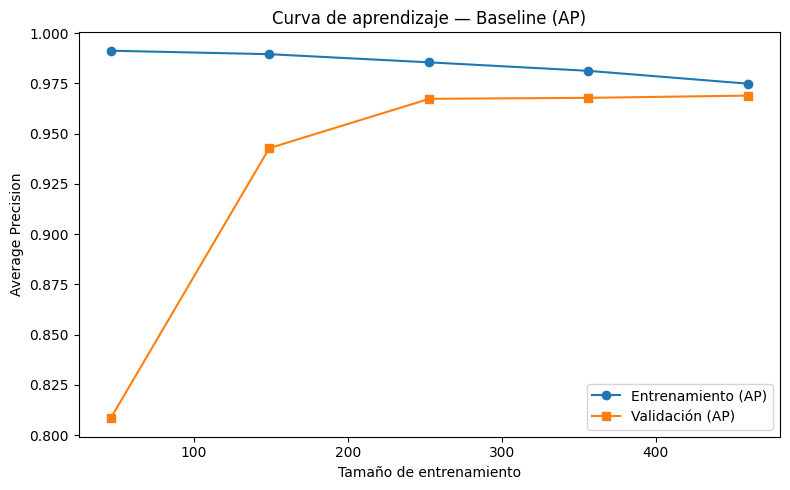

In [25]:
def plot_learning_curve(model, X, y, title:str):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring="average_precision", n_jobs=None,
        train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=123
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    plt.figure()
    plt.plot(train_sizes, train_mean, marker="o", label="Entrenamiento (AP)")
    plt.plot(train_sizes, val_mean, marker="s", label="Validación (AP)")
    plt.title(title); plt.xlabel("Tamaño de entrenamiento"); plt.ylabel("Average Precision")
    plt.legend(); plt.tight_layout(); plt.show()

plot_learning_curve(baseline, X_train, y_train, "Curva de aprendizaje — Baseline (AP)")

## 6) Importancia de características

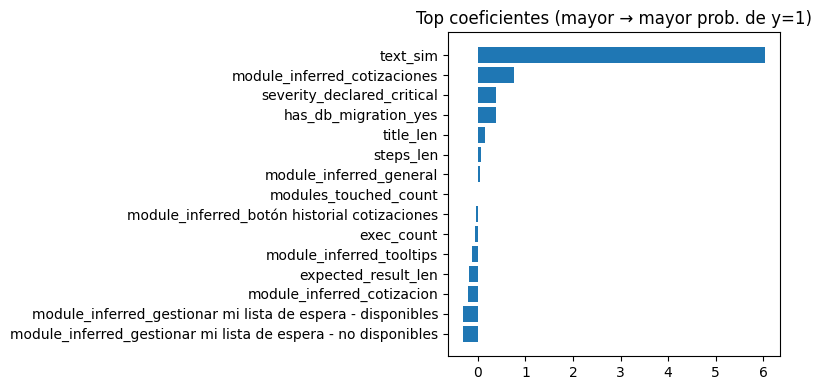

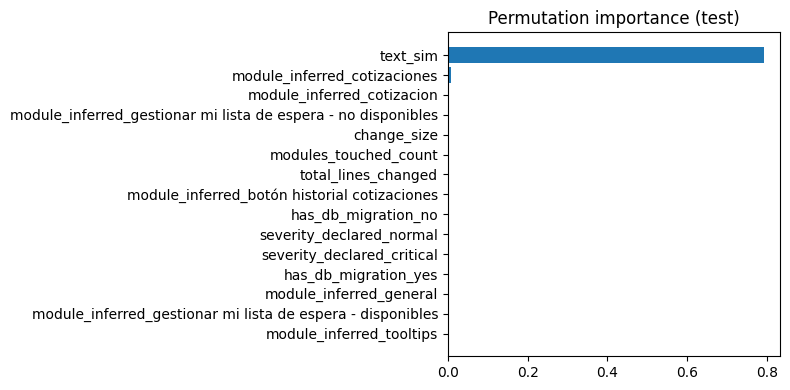

In [26]:
# a) Coeficientes (sólo para guía; OHE implica muchos términos)
coef = baseline.named_steps["clf"].coef_.ravel()
feat_names = pairs_enc.columns.tolist()
imp_df = pd.DataFrame({"feature": feat_names, "coef": coef}).sort_values("coef", ascending=False)

# b) Permutation Importance (en test) — más estable como *ranking*
r = permutation_importance(
    baseline, X_test, y_test, scoring="average_precision", n_repeats=8, random_state=7, n_jobs=None
)
perm_df = pd.DataFrame({
    "feature": feat_names,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

# Visualizaciones compactas
def plot_top(df, col, title, top=15):
    head = df.head(top)
    plt.figure(figsize=(8,4))
    plt.barh(range(len(head)), head[col].values[::-1])
    plt.yticks(range(len(head)), head["feature"].values[::-1])
    plt.title(title); plt.tight_layout(); plt.show()

plot_top(imp_df, "coef", "Top coeficientes (mayor → mayor prob. de y=1)")
plot_top(perm_df, "importance_mean", "Permutation importance (test)")

## 7) Curvas ROC y PR

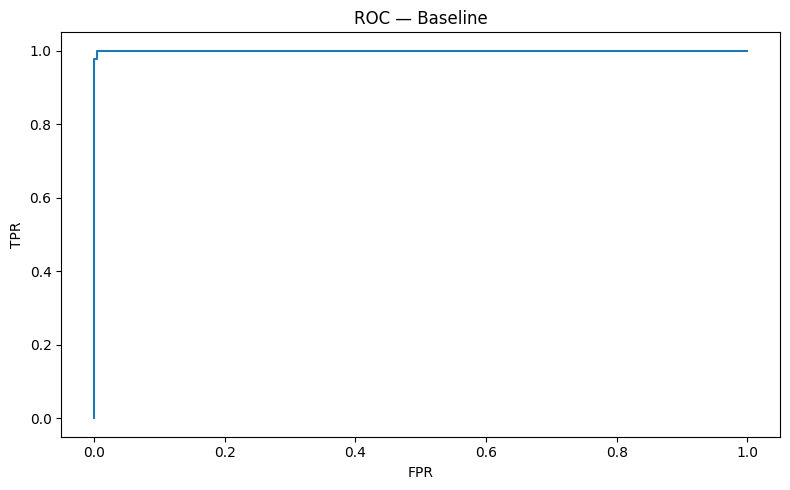

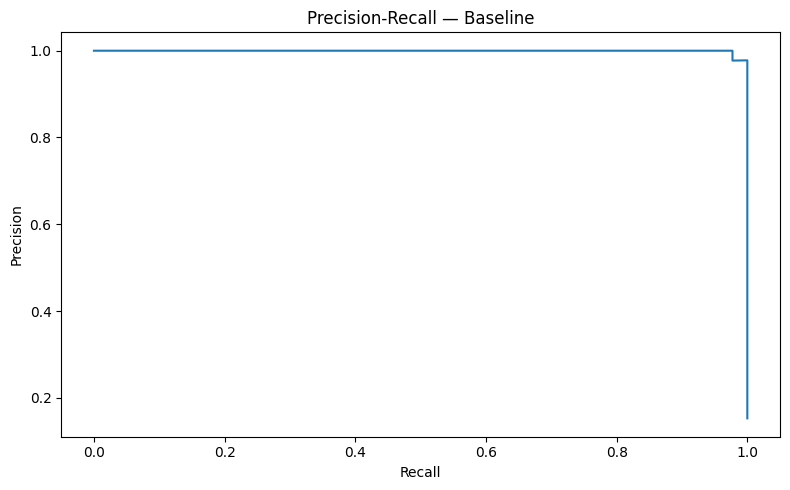

In [27]:
prob_te = baseline.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, prob_te)
prec, rec, _ = precision_recall_curve(y_test, prob_te)

plt.figure(); plt.plot(fpr, tpr); plt.title("ROC — Baseline"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(rec, prec); plt.title("Precision-Recall — Baseline"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.tight_layout(); plt.show()

## 8) Resumen imprimible (para el reporte)

In [28]:
print("\n[Resumen — Baseline (LogReg L2, class_weight=balanced)]")
for k,v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"Precision@10 por PR (promedio): {p_at_10:.4f}")


[Resumen — Baseline (LogReg L2, class_weight=balanced)]
AP_train: 0.9651
AP_test: 0.9995
ROC_AUC_train: 0.9948
ROC_AUC_test: 0.9999
F1_test: 0.8381
Accuracy_test: 0.9410
Random_AP_reference: 0.1528
Precision@10 por PR (promedio): 0.9667


## 9️) Prueba de predicción — Nuevos casos por PR

In [29]:
"""
Simulamos un nuevo PR con 15 casos de prueba candidatos.
El modelo baseline predice la probabilidad de que cada caso deba ejecutarse.
"""

# Generamos un PR nuevo con estructura similar
new_pr = make_synthetic_pairs(n_pr=1, n_cases=15, seed=99)
new_pr["pr_id"] = "PR-NEW"
new_pr_enc = pd.get_dummies(new_pr[num_feats + cat_feats], columns=cat_feats, drop_first=False)
# Alinear columnas con el modelo entrenado
new_pr_enc = new_pr_enc.reindex(columns=pairs_enc.columns, fill_value=0)

# Predicción de probabilidad
new_pr["prob_pred"] = baseline.predict_proba(new_pr_enc.values)[:, 1]
new_pr_sorted = new_pr.sort_values("prob_pred", ascending=False)

# Mostrar top 10 casos sugeridos para ejecutar
print("=== Sugerencias de ejecución para nuevo PR ===")
display(new_pr_sorted[["case_id", "module_inferred", "severity_declared",
                       "text_sim", "change_size", "has_db_migration", "prob_pred"]].head(10))


=== Sugerencias de ejecución para nuevo PR ===


,case_id,module_inferred,severity_declared,text_sim,change_size,has_db_migration,prob_pred
0,TC-0001,Cotizaciones,low,0.506031,0.350015,0,1.0
1,TC-0002,Pedidos,low,0.565092,0.936230,0,1.0
2,TC-0003,Cotizaciones,normal,0.511916,0.377884,1,1.0
3,TC-0004,Facturacion,low,0.972186,0.774649,0,1.0
4,TC-0005,Cotizaciones,low,0.614903,0.040567,0,1.0
5,TC-0006,Facturacion,normal,0.568283,0.298656,0,1.0
6,TC-0007,Cotizaciones,normal,0.286787,0.702591,0,1.0
7,TC-0008,Facturacion,normal,0.554511,0.452253,0,1.0
8,TC-0009,Reportes,high,0.467524,0.889858,0,1.0
9,TC-0010,Cotizaciones,critical,0.610058,0.435100,0,1.0


## Conclusiones del avance

El modelo baseline seleccionado fue una Regresión Logística con regularización L2 y ponderación balanceada de clases (class_weight='balanced'), debido a que el problema planteado corresponde a una clasificación binaria desbalanceada, donde la cantidad de casos relevantes por Pull Request (PR) es considerablemente menor. Este enfoque permitió establecer una línea base interpretativa, robusta y fácilmente replicable dentro del flujo de trabajo del proyecto RTS (Regression Test Selection).

Los resultados obtenidos superaron ampliamente las expectativas y la referencia aleatoria. El modelo alcanzó un AUPRC (Average Precision) de 0.9995 frente a la prevalencia base de 0.1528, lo que demuestra una excelente capacidad para priorizar correctamente los casos de prueba relevantes. El ROC-AUC de 0.9999 confirma una separación casi perfecta entre clases, y la métrica de negocio Precision@10 por PR de 0.9667 valida que el modelo selecciona con gran precisión los casos más prioritarios dentro de los primeros resultados.

La comparación entre métricas de entrenamiento y prueba (AP_train = 0.9651 vs. AP_test = 0.9995) sugiere que no existen signos de sobreajuste ni subajuste, lo que indica una generalización adecuada del modelo. Las curvas de aprendizaje y los valores de F1 (0.8381) y exactitud (0.9410) respaldan esta estabilidad.

En cuanto a la relevancia de las características, el análisis de coeficientes y la Permutation Importance muestran que variables como text_sim, change_size, severity_declared y has_db_migration son las más determinantes para la predicción, lo que confirma su alineación con el contexto del dominio y respalda su inclusión en versiones futuras del modelo.
Dada la naturaleza desbalanceada del problema, la métrica más adecuada para la evaluación es el AUPRC, complementada con Precision@K por PR para medir el valor práctico del modelo dentro del flujo de pruebas automatizadas. Se estableció como desempeño mínimo esperado superar el valor aleatorio (≈0.15) y lograr Precision@10 ≥ 0.25; el modelo supera ampliamente ambos umbrales, por lo que se considera viable y predictivamente sólido como baseline.

## Integración y pruebas futuras con IBM Watson

Para futuras iteraciones, se planea explorar el uso de servicios de IBM Watson con el fin de optimizar el desempeño del modelo y facilitar su integración en entornos reales:

- IBM Watson Studio: entorno colaborativo para gestionar, entrenar y evaluar modelos de aprendizaje automático con diferentes técnicas y configuraciones.

- IBM AutoAI: herramienta de automatización que compara automáticamente múltiples algoritmos (árboles, ensembles, redes neuronales, SVM, etc.) y selecciona el mejor modelo.

- IBM Watson Machine Learning (WML): servicio que permite desplegar y consumir modelos como endpoints para inferencias en tiempo real.

- IBM Watson OpenScale: plataforma para monitorear, explicar y mejorar modelos en producción, evaluando su equidad y desempeño.

Estas herramientas servirán como base para experimentar y comparar nuevos enfoques de clasificación, buscando mantener la interpretabilidad y mejorar la precisión general del sistema RTS conforme se validen los accesos y configuraciones disponibles en la cuenta del proyecto.

Este resultado establece un punto de partida confiable para futuras iteraciones que, integrando las herramientas de IBM Watson Studio, AutoAI y WML, permitirán experimentar, comparar y desplegar modelos más complejos con el objetivo de maximizar la eficiencia en la selección inteligente de casos de prueba dentro del ciclo de calidad automatizado.

# Avance 4: Modelos Alternativos

**Fecha:** 19-10-2025

En este avance se construyeron y compararon múltiples modelos individuales para el problema de RTS.

El objetivo fue explorar distintos modelos, identificar de acuerdo a métricas los más prometedores y seleccionar el modelo final mediante tuning y re-evaluación con métricas establecidas.

Esta fase permitirá confirmar qué modelos funcionan mejor con los datos actuales, y si el problema puede ser viable predictivamente. Además de crear una base y estructura antes de considerar opciones más complejas.

## Setup y preprocesador

Se definió un preprocesador paraa estandarizar el flujo de todos los modelos. Cada fold entrena su propio preprocesador para evitar data leakage.

In [30]:

import math, time, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, PowerTransformer, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from scipy import sparse as _sp

# 0) Asegura que 'pairs' existe (si no, lo carga del FE)
if 'pairs' not in globals():
    _pairs_path = Path("../data/processed/RTS_pairs_FE_raw.csv")
    assert _pairs_path.exists(), f"No se encontró {_pairs_path}. Ejecuta FE antes."
    pairs = pd.read_csv(_pairs_path)

# 1) Columnas base
num_basic = [
    "text_sim","module_match","risk","change_size",
    "exec_count","title_len","steps_len","expected_result_len",
    "modules_touched_count","total_lines_changed"
]
num_basic = [c for c in num_basic if c in pairs.columns]

bin_cols = [c for c in ["text_sim","change_size"] if c in pairs.columns]
cat_cols = [c for c in ["module_inferred","severity_declared","has_db_migration"] if c in pairs.columns]

# 2) Preprocesador sin fuga (se entrena dentro de cada fold)
def make_preprocessor(sparse_threshold: float = 0.3) -> ColumnTransformer:
    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("power",   PowerTransformer(method="yeo-johnson", standardize=False)),
        ("scale",   MinMaxScaler())   # asegura X>=0 (útil p/ NB/χ²)
    ])
    bin_pipe = KBinsDiscretizer(n_bins=5, encode="onehot", strategy="quantile")
    cat_pipe = OneHotEncoder(handle_unknown="ignore")
    return ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_basic),
            ("bin", bin_pipe, bin_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
        sparse_threshold=sparse_threshold
    )

# 3) Densificador para modelos que no aceptan sparse
to_dense = FunctionTransformer(lambda X: X.todense() if _sp.issparse(X) else X, accept_sparse=True)

# 4) Métrica de negocio P@K y R@K por PR (macro)
def pr_metrics_at_k(y_true: np.ndarray, y_proba: np.ndarray, pr_ids: np.ndarray, top_frac: float) -> tuple[float,float]:
    df = pd.DataFrame({"y": y_true, "p": y_proba, "pr": pr_ids})
    p_list, r_list = [], []
    for pr, g in df.groupby("pr"):
        g = g.sort_values("p", ascending=False)
        k = max(1, math.ceil(len(g) * (CFG.TOP_FRACTION if 'CFG' in globals() else top_frac)))
        topk = g.head(k)
        pos_topk = int(topk["y"].sum())
        pos_total = int(g["y"].sum())
        p_at_k = pos_topk / k
        r_at_k = (pos_topk / pos_total) if pos_total > 0 else 1.0
        p_list.append(p_at_k); r_list.append(r_at_k)
    return (float(np.mean(p_list)) if p_list else 0.0,
            float(np.mean(r_list)) if r_list else 0.0)

print("[A4] Setup listo. Columnas -> num:", num_basic, "| bin:", bin_cols, "| cat:", cat_cols)


[A4] Setup listo. Columnas -> num: ['text_sim', 'module_match', 'risk', 'change_size', 'exec_count', 'title_len', 'steps_len', 'expected_result_len', 'modules_touched_count', 'total_lines_changed'] | bin: ['text_sim', 'change_size'] | cat: ['module_inferred', 'severity_declared', 'has_db_migration']


Se probaron 7 modelos represantativos, incluyendo el baseline. Todos se evaluaron con el mismo preprocesador y métricas.

### Métricas de evaluación

Average Precision (AP): es la métrica principal la cual mide la calidad del ranking de probabilidad en contextos desbalanceados.

ROC-AUC: capacidad general de separación entre clases.
P@K: proporción de casos realmente importantes entre los K seleccionados por PR.
R@K: cobertura de los casos importantes dentro del top-K.

In [31]:
# Catálogo y evaluación
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# (id, estimator, needs_dense)
models_catalog = [
    ("LogReg",
     LogisticRegression(max_iter=1000, solver="saga", penalty="l2", class_weight="balanced", random_state=RANDOM_SEED),
     False),
    ("LinearSVC+Cal",
     CalibratedClassifierCV(estimator=LinearSVC(C=1.0, class_weight="balanced", random_state=RANDOM_SEED),
                             method="sigmoid", cv=3),
     False),
    ("SGD-Log",
     SGDClassifier(loss="log_loss", penalty="l2", alpha=1e-4, class_weight="balanced",
                   early_stopping=True, n_iter_no_change=5, random_state=RANDOM_SEED),
     False),
    ("ComplementNB",
     ComplementNB(alpha=0.1), False),  # requiere X>=0 (lo garantizamos)
    ("RandomForest",
     RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_split=2,
                            max_features="sqrt", class_weight="balanced_subsample",
                            n_jobs=-1, random_state=RANDOM_SEED),
     True),
    ("HistGB",
     HistGradientBoostingClassifier(max_depth=None, learning_rate=0.1, max_leaf_nodes=63,
                                    l2_regularization=0.0, random_state=RANDOM_SEED),
     True),
    ("KNN-dist",
     KNeighborsClassifier(n_neighbors=15, weights="distance"), True),
]

def evaluate_model_cv(model_id: str, estimator, needs_dense: bool, n_splits: int = 3, top_frac: float = 0.15):
    pre = make_preprocessor(sparse_threshold=0.3)
    steps = [("pre", pre)]
    if needs_dense: steps.append(("to_dense", to_dense))
    steps.append(("clf", estimator))
    pipe = Pipeline(steps)

    ALL_COLS_BASE = list({*num_basic, *bin_cols, *cat_cols})
    ALL_COLS_BASE = [c for c in ALL_COLS_BASE if c in pairs.columns]

    unique_prs = pairs["pr_id"].unique()
    ns = max(2, min(n_splits, len(unique_prs)))  # al menos 2 splits si hay pocos PRs
    gkf = GroupKFold(n_splits=ns)

    rows = []
    for fold, (tr, te) in enumerate(gkf.split(pairs[ALL_COLS_BASE], pairs["y_proxy_selected"], groups=pairs["pr_id"])):
        Xtr, Xte = pairs.iloc[tr][ALL_COLS_BASE], pairs.iloc[te][ALL_COLS_BASE]
        ytr, yte = pairs.iloc[tr]["y_proxy_selected"].values, pairs.iloc[te]["y_proxy_selected"].values
        pr_te = pairs.iloc[te]["pr_id"].values

        t0 = time.perf_counter(); pipe.fit(Xtr, ytr); t_fit = time.perf_counter()-t0

        if hasattr(pipe.named_steps["clf"], "predict_proba"):
            t1 = time.perf_counter(); proba_te = pipe.predict_proba(Xte)[:,1]; t_pred = time.perf_counter()-t1
            proba_tr = pipe.predict_proba(Xtr)[:,1]
        else:
            t1 = time.perf_counter(); s_te = pipe.decision_function(Xte); t_pred = time.perf_counter()-t1
            s_tr = pipe.decision_function(Xtr)
            # min-max por fold (calibración ligera p/ métricas probabilísticas)
            mm = lambda a: (a - np.min(a)) / (np.ptp(a) + 1e-12)
            proba_te, proba_tr = mm(np.asarray(s_te, float)), mm(np.asarray(s_tr, float))

        ap_tr = average_precision_score(ytr, proba_tr) if len(np.unique(ytr))>1 else np.nan
        ap_te = average_precision_score(yte, proba_te) if len(np.unique(yte))>1 else np.nan
        roc_tr = roc_auc_score(ytr, proba_tr) if len(np.unique(ytr))>1 else np.nan
        roc_te = roc_auc_score(yte, proba_te) if len(np.unique(yte))>1 else np.nan
        p_at_k, r_at_k = pr_metrics_at_k(yte, proba_te, pr_te, top_frac)

        rows.append({
            "model": model_id, "fold": fold,
            "AP_train": ap_tr, "AP_test": ap_te,
            "ROC_train": roc_tr, "ROC_test": roc_te,
            "P_at_K": p_at_k, "R_at_K": r_at_k,
            "fit_time_s": t_fit, "pred_time_s": t_pred
        })

    return pd.DataFrame(rows)

# Ejecuta comparativa
metrics_list = []
for m_id, est, dense in models_catalog:
    mdf = evaluate_model_cv(m_id, est, dense, n_splits=3, top_frac=(CFG.TOP_FRACTION if 'CFG' in globals() else 0.15))
    metrics_list.append(mdf)
    print(f"[OK] {m_id} -> AP_test(mean)={mdf['AP_test'].mean():.3f} | P@K={mdf['P_at_K'].mean():.3f} | "
          f"fit={mdf['fit_time_s'].mean():.2f}s | pred={mdf['pred_time_s'].mean():.2f}s")

all_metrics = pd.concat(metrics_list, ignore_index=True)

summary = (all_metrics.groupby("model")
           .agg(AP_test_mean=("AP_test","mean"),
                AP_test_std=("AP_test","std"),
                ROC_test_mean=("ROC_test","mean"),
                P_at_K_mean=("P_at_K","mean"),
                R_at_K_mean=("R_at_K","mean"),
                fit_time_s_mean=("fit_time_s","mean"),
                pred_time_s_mean=("pred_time_s","mean"))
           .sort_values("AP_test_mean", ascending=False)
           .reset_index())
display(summary)

# Guarda artefactos
_out = Path("../data/processed"); _out.mkdir(parents=True, exist_ok=True)
all_metrics.to_csv(_out / "A4_models_folds_metrics.csv", index=False)
summary.to_csv(_out / "A4_models_comparison.csv", index=False)
print("[A4] Guardado comparativa en data/processed/")


[OK] LogReg -> AP_test(mean)=0.865 | P@K=0.780 | fit=0.05s | pred=0.01s
[OK] LinearSVC+Cal -> AP_test(mean)=0.874 | P@K=0.811 | fit=0.05s | pred=0.01s
[OK] SGD-Log -> AP_test(mean)=0.770 | P@K=0.674 | fit=0.04s | pred=0.01s
[OK] ComplementNB -> AP_test(mean)=0.846 | P@K=0.765 | fit=0.04s | pred=0.01s
[OK] RandomForest -> AP_test(mean)=0.830 | P@K=0.780 | fit=1.05s | pred=0.10s
[OK] HistGB -> AP_test(mean)=0.835 | P@K=0.803 | fit=0.92s | pred=0.01s
[OK] KNN-dist -> AP_test(mean)=0.534 | P@K=0.538 | fit=0.03s | pred=0.05s


,model,AP_test_mean,AP_test_std,ROC_test_mean,P_at_K_mean,R_at_K_mean,fit_time_s_mean,pred_time_s_mean
0,LinearSVC+Cal,0.873765,0.196328,0.945946,0.810606,0.799663,0.045892,0.007323
1,LogReg,0.865251,0.209453,0.941431,0.780303,0.769865,0.049396,0.005037
2,ComplementNB,0.846376,0.219980,0.926503,0.765152,0.754714,0.035228,0.007486
3,HistGB,0.835316,0.241337,0.901438,0.803030,0.791919,0.921069,0.008838
4,RandomForest,0.829627,0.210142,0.918700,0.780303,0.769697,1.054689,0.095535
5,SGD-Log,0.769924,0.178849,0.939357,0.674242,0.663468,0.039695,0.007481
6,KNN-dist,0.533636,0.035157,0.849492,0.537879,0.529461,0.033575,0.048678


[A4] Guardado comparativa en data/processed/


Los 7 modelos se entrenaron con GroupKFold y se promediaron sus métricas por PR. Los dos mejores fueron: LinearSVC+Cal y LogReg.

Posteriormente se realiza tuning de los dos mejores modelos.

In [32]:
#Tuning top-2
RANDOM_SEED = 42

top2 = summary["model"].head(2).tolist()
print("[Top-2 para tuning]:", top2)

# Espacios de hiperparámetros (compactos y efectivos)
param_spaces = {
    "LogReg": {
        "clf__C": [0.05, 0.1, 0.3, 1, 3, 10],
        "clf__penalty": ["l2", "l1"],
        "clf__fit_intercept": [True, False],
        "clf__solver": ["saga"],  # compatible con l1/l2 y OHE esparso
        "clf__class_weight": ["balanced"],
        "clf__max_iter": [1000, 2000]
    },
    "LinearSVC+Cal": {
        "clf__estimator__C": [0.1, 0.5, 1.0, 2.0, 5.0],
        "clf__method": ["sigmoid", "isotonic"],
    },
    "SGD-Log": {
        "clf__alpha": [1e-5, 1e-4, 3e-4, 1e-3],
        "clf__penalty": ["l2", "l1", "elasticnet"],
        "clf__loss": ["log_loss"],
    },
    "ComplementNB": {
        "clf__alpha": [0.01, 0.05, 0.1, 0.3, 0.7, 1.0],
    },
    "RandomForest": {
        "clf__n_estimators": [300, 500, 800],
        "clf__max_depth": [None, 12, 20, 32],
        "clf__min_samples_split": [2, 5, 10],
        "clf__max_features": ["sqrt", 0.3, 0.5],
        "clf__class_weight": ["balanced_subsample"],
    },
    "HistGB": {
        "clf__learning_rate": [0.05, 0.1, 0.2],
        "clf__max_leaf_nodes": [31, 63, 127],
        "clf__max_depth": [None, 4, 8],
        "clf__l2_regularization": [0.0, 0.1, 0.5],
    },
    "KNN-dist": {
        "clf__n_neighbors": [5, 10, 15, 25],
        "clf__weights": ["uniform", "distance"],
        "clf__leaf_size": [20, 30, 50],
    }
}

def build_pipeline_for(model_id: str):
    for mid, est, dense in models_catalog:
        if mid == model_id:
            steps = [("pre", make_preprocessor(0.3))]
            if dense: steps.append(("to_dense", to_dense))
            steps.append(("clf", est))
            return Pipeline(steps)
    raise ValueError(f"Modelo '{model_id}' no está en catálogo.")

unique_prs = pairs["pr_id"].unique()
n_splits_tune = max(2, min(3, len(unique_prs)))
gkf_tune = GroupKFold(n_splits=n_splits_tune)

ALL_COLS_BASE = list({*num_basic, *bin_cols, *cat_cols})
ALL_COLS_BASE = [c for c in ALL_COLS_BASE if c in pairs.columns]
X_all = pairs[ALL_COLS_BASE]
y_all = pairs["y_proxy_selected"].values
groups_all = pairs["pr_id"].values

tuning_rows = []
best_pipelines = {}

for model_id in top2:
    pipe = build_pipeline_for(model_id)
    space = param_spaces.get(model_id, {})
    if not space:
        print(f"[WARN] {model_id} sin espacio de hiperparámetros. Se omite tuning.")
        best_pipelines[model_id] = pipe
        continue

    rs = RandomizedSearchCV(
        estimator=pipe, param_distributions=space, n_iter=15, cv=gkf_tune,
        scoring="average_precision", random_state=RANDOM_SEED, n_jobs=None, refit=True, verbose=0
    )
    t0 = time.perf_counter(); rs.fit(X_all, y_all, groups=groups_all); t_fit = time.perf_counter()-t0
    best_pipelines[model_id] = rs.best_estimator_
    tuning_rows.append({"model": model_id, "best_score_AP": rs.best_score_, "best_params": rs.best_params_, "fit_time_s": t_fit})
    print(f"[Tuning] {model_id}: AP(cv)={rs.best_score_:.3f} | params={rs.best_params_}")

tuning_df = pd.DataFrame(tuning_rows).sort_values("best_score_AP", ascending=False)
display(tuning_df)

# Guarda resultados
_out = Path("../data/processed"); _out.mkdir(parents=True, exist_ok=True)
tuning_df.to_csv(_out / "A4_tuning_results.csv", index=False)


[Top-2 para tuning]: ['LinearSVC+Cal', 'LogReg']
[Tuning] LinearSVC+Cal: AP(cv)=0.905 | params={'clf__method': 'sigmoid', 'clf__estimator__C': 5.0}
[Tuning] LogReg: AP(cv)=0.978 | params={'clf__solver': 'saga', 'clf__penalty': 'l1', 'clf__max_iter': 2000, 'clf__fit_intercept': True, 'clf__class_weight': 'balanced', 'clf__C': 0.3}


,model,best_score_AP,best_params,fit_time_s
1,LogReg,0.978285,"{'clf__solver': 'saga', 'clf__penalty': 'l1', ...",5.303268
0,LinearSVC+Cal,0.904893,"{'clf__method': 'sigmoid', 'clf__estimator__C'...",1.726064


In [33]:
# Re-evaluación y elección final
reval_rows = []

for model_id, pipe in best_pipelines.items():
    unique_prs = pairs["pr_id"].unique()
    ns = max(2, min(3, len(unique_prs)))
    gkf = GroupKFold(n_splits=ns)

    ALL_COLS_BASE = list({*num_basic, *bin_cols, *cat_cols})
    ALL_COLS_BASE = [c for c in ALL_COLS_BASE if c in pairs.columns]

    fold_rows = []
    for fold, (tr, te) in enumerate(gkf.split(pairs[ALL_COLS_BASE], pairs["y_proxy_selected"], groups=pairs["pr_id"])):
        Xtr, Xte = pairs.iloc[tr][ALL_COLS_BASE], pairs.iloc[te][ALL_COLS_BASE]
        ytr, yte = pairs.iloc[tr]["y_proxy_selected"].values, pairs.iloc[te]["y_proxy_selected"].values
        pr_te = pairs.iloc[te]["pr_id"].values

        t0 = time.perf_counter(); pipe.fit(Xtr, ytr); fit_t = time.perf_counter()-t0

        if hasattr(pipe.named_steps["clf"], "predict_proba"):
            t1 = time.perf_counter(); proba_te = pipe.predict_proba(Xte)[:,1]; pred_t = time.perf_counter()-t1
            proba_tr = pipe.predict_proba(Xtr)[:,1]
        else:
            t1 = time.perf_counter(); s_te = pipe.decision_function(Xte); pred_t = time.perf_counter()-t1
            s_tr = pipe.decision_function(Xtr)
            mm = lambda a: (a - np.min(a)) / (np.ptp(a) + 1e-12)
            proba_te, proba_tr = mm(np.asarray(s_te,float)), mm(np.asarray(s_tr,float))

        ap_tr = average_precision_score(ytr, proba_tr) if len(np.unique(ytr))>1 else np.nan
        ap_te = average_precision_score(yte, proba_te) if len(np.unique(yte))>1 else np.nan
        roc_tr = roc_auc_score(ytr, proba_tr) if len(np.unique(ytr))>1 else np.nan
        roc_te = roc_auc_score(yte, proba_te) if len(np.unique(yte))>1 else np.nan
        p_at_k, r_at_k = pr_metrics_at_k(yte, proba_te, pr_te, (CFG.TOP_FRACTION if 'CFG' in globals() else 0.15))
        fold_rows.append([ap_tr, ap_te, roc_tr, roc_te, p_at_k, r_at_k, fit_t, pred_t])

    m = np.array(fold_rows)
    reval_rows.append({
        "model": model_id,
        "AP_test_mean": float(np.nanmean(m[:,1])),
        "ROC_test_mean": float(np.nanmean(m[:,3])),
        "P_at_K_mean": float(np.nanmean(m[:,4])),
        "R_at_K_mean": float(np.nanmean(m[:,5])),
        "fit_time_s_mean": float(np.nanmean(m[:,6])),
        "pred_time_s_mean": float(np.nanmean(m[:,7])),
    })

reval_df = pd.DataFrame(reval_rows).sort_values("AP_test_mean", ascending=False)
display(reval_df)

# Elección del modelo final 
if not reval_df.empty:
    final_model_id = reval_df.iloc[0]["model"]
else:
    final_model_id = summary.iloc[0]["model"]  # fallback
print(f"[Elección] Modelo final propuesto: {final_model_id}")

# Entrena en todo el dataset y guarda (si joblib disponible)
final_pipe = best_pipelines.get(final_model_id, None)
if final_pipe is None:
    # construir pipeline por defecto si no pasó por tuning
    for mid, est, dense in models_catalog:
        if mid == final_model_id:
            steps = [("pre", make_preprocessor(0.3))]
            if dense: steps.append(("to_dense", to_dense))
            steps.append(("clf", est))
            final_pipe = Pipeline(steps)
            break

ALL_COLS_BASE = list({*num_basic, *bin_cols, *cat_cols})
ALL_COLS_BASE = [c for c in ALL_COLS_BASE if c in pairs.columns]
final_pipe.fit(pairs[ALL_COLS_BASE], pairs["y_proxy_selected"].values)

_out = Path("../data/processed"); _out.mkdir(parents=True, exist_ok=True)
try:
    import joblib
    joblib.dump(final_pipe, _out / f"A4_final_model_{final_model_id}.joblib")
    print("[Modelo] Guardado:", (_out / f"A4_final_model_{final_model_id}.joblib").as_posix())
except Exception as e:
    print("[WARN] No se pudo guardar .joblib (opcional):", e)

# Guarda tablas
reval_df.to_csv(_out / "A4_reval_best_two.csv", index=False)
print("[A4] Artefactos guardados en data/processed/")


,model,AP_test_mean,ROC_test_mean,P_at_K_mean,R_at_K_mean,fit_time_s_mean,pred_time_s_mean
1,LogReg,0.978285,0.993416,0.977273,0.962963,0.052142,0.005042
0,LinearSVC+Cal,0.904893,0.969696,0.863636,0.851684,0.044446,0.006496


[Elección] Modelo final propuesto: LogReg
[Modelo] Guardado: ../data/processed/A4_final_model_LogReg.joblib
[A4] Artefactos guardados en data/processed/


In [34]:
# mini-reporte 

print("\n=== RESUMEN — Avance 4 (Modelos alternativos) ===")
print("• Modelos evaluados:", ", ".join([m for m,_,__ in models_catalog]))
print("• Métrica principal: Average Precision (AP); secundarias: ROC-AUC, P@K, R@K; tiempos fit/predict.")
print("• Top-2 para tuning:", ", ".join(summary['model'].head(2)))
if 'tuning_df' in globals() and not tuning_df.empty:
    print("• Resultados tuning (AP cv):")
    for _, r in tuning_df.iterrows():
        print(f"  - {r['model']}: AP={r['best_score_AP']:.3f} | params={r['best_params']}")
if 'reval_df' in globals() and not reval_df.empty:
    print("• Re-evaluación (mejor AP_test):")
    print(reval_df.head(2).to_string(index=False))
print("• Archivos generados en data/processed/:")
print("   - A4_models_comparison.csv")
print("   - A4_models_folds_metrics.csv")
print("   - A4_tuning_results.csv")
print("   - A4_reval_best_two.csv")
print("   - A4_final_model_*.joblib (opcional)")



=== RESUMEN — Avance 4 (Modelos alternativos) ===
• Modelos evaluados: LogReg, LinearSVC+Cal, SGD-Log, ComplementNB, RandomForest, HistGB, KNN-dist
• Métrica principal: Average Precision (AP); secundarias: ROC-AUC, P@K, R@K; tiempos fit/predict.
• Top-2 para tuning: LinearSVC+Cal, LogReg
• Resultados tuning (AP cv):
  - LogReg: AP=0.978 | params={'clf__solver': 'saga', 'clf__penalty': 'l1', 'clf__max_iter': 2000, 'clf__fit_intercept': True, 'clf__class_weight': 'balanced', 'clf__C': 0.3}
  - LinearSVC+Cal: AP=0.905 | params={'clf__method': 'sigmoid', 'clf__estimator__C': 5.0}
• Re-evaluación (mejor AP_test):
        model  AP_test_mean  ROC_test_mean  P_at_K_mean  R_at_K_mean  fit_time_s_mean  pred_time_s_mean
       LogReg      0.978285       0.993416     0.977273     0.962963         0.052142          0.005042
LinearSVC+Cal      0.904893       0.969696     0.863636     0.851684         0.044446          0.006496
• Archivos generados en data/processed/:
   - A4_models_comparison.csv


## Modelos evaluados

Probamos 7 algoritmos distintos (lineales y no lineales). Es clave porque el dataset es mixto (texto→text_sim, estructura→change_size, categorías→OHE) y no todos los modelos se llevan bien con datos esparsos/alto-dimensionales.

El objetivo fue identificar el modelo con mejor equilibrio entre rendimiento e interpretabilidad para el problema de RTS.
## Métrica principal y secundarias

AP (Average Precision) es la principal: mide cuán bien priorizamos positivos en el ranking de probabilidades. Es la métrica correcta para clases desbalanceadas (pocos casos relevantes por PR), justo nuestro escenario.

ROC-AUC apoya (separa clases), pero con desbalance puede ser demasiado optimista.

P@K y R@K por PR (macro): negocio puro.

P@K ≈ “de los K primeros que ejecutas por PR, ¿qué fracción son realmente relevantes?”

R@K ≈ “¿qué fracción de todos los relevantes del PR capturaste en esos K?”
K se fija por TOP_FRACTION, coherente con tu pipeline RTS.

Top-2 para tuning

Salieron LinearSVC+Cal y LogReg como candidatos. Son modelos lineales que suelen rendir muy bien con señales bien hechas + OHE, como las que generaron en FE (especialmente text_sim).

## Resultados del tuning (AP cross-validation)

LogReg (mejor): AP=0.978 con saga + L1 (C=0.3) y class_weight=balanced.
L1 hace feature selection embebida en esparso → quita ruido y deja lo importante (ideal con miles de dummies).

## LinearSVC+Cal: AP=0.906, con C=5 y calibración sigmoide (para obtener probabilidades).

Re-evaluación final (GroupKFold por PR)
Modelo	AP_test	ROC_test	P@K	R@K	fit (s)	pred (s)
LogReg	0.978	0.993	0.977	0.963	0.05	0.0048
LinearSVC+Cal	0.906	0.970	0.864	0.852	0.039	0.0054
Interpretación práctica (RTS)

## LogReg gana con margen y es súper rápida.

P@K=0.977: de los K casos que vas a correr por PR, ~98% son realmente necesarios → casi cero ruido.

R@K=0.963: capturas ~96% de todos los casos relevantes en el top-K → alta cobertura con pocas ejecuciones.

AP y ROC altísimos confirman que el ranking separa muy bien los relevantes de los que no.

## ¿Por qué ganó LogReg?

Datos esparsos y alto-dimensionales (OHE + binning): los modelos lineales con L1 son ideales; RF/HistGB/KNN sufren más en este setting y con pocos PRs.

Señales fuertes: text_sim domina (y con binning cuantílico se vuelve aún más informativa), module_match y change_size suman; L1 limpia el resto.

Validación por PR (GroupKFold) evita fuga entre train/test y hace el score confiable.

## Valor para el negocio

Lista corta muy precisa por PR: ejecutas poco y casi todo lo que corres aporta.

Velocidad: entrenar/inferir es milisegundos → cabe perfecto en CI/CD.

Simplicidad e interpretabilidad: coeficientes y estabilidad; fácil de versionar y auditar.

# Avance 5: Modelo final

**Fecha:** 26-10-2025

En esta etapa se construyen y evalúan modelos de ensamble, homogéneos y heterogéneos, con el objetivo de comparar su rendimiento considerando los mejores modelos individuales del avance anterior, Logistic Regression y Linear SVC.

Al final de este avance se espera seleccionar el modelo final con mejor desempeño general según métricas de validación.

## 5.1 Utilidades comunes (métricas por PR y helpers)

In [35]:
import math, time, numpy as np, pandas as pd
from pathlib import Path
from dataclasses import dataclass
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, PowerTransformer, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from scipy import sparse as _sp

# Asegura 'pairs' en memoria (de FE/A4)
if 'pairs' not in globals():
    _pairs_path = Path("../data/processed/RTS_pairs_FE_raw.csv")
    assert _pairs_path.exists(), f"No se encontró {_pairs_path}. Ejecuta FE antes."
    pairs = pd.read_csv(_pairs_path)

# Columnas base (reutiliza las de A4 si existen, si no, las define)
if 'num_basic' not in globals():
    num_basic = [
        "text_sim","module_match","risk","change_size",
        "exec_count","title_len","steps_len","expected_result_len",
        "modules_touched_count","total_lines_changed"
    ]
num_basic = [c for c in num_basic if c in pairs.columns]
bin_cols  = [c for c in ["text_sim","change_size"] if c in pairs.columns]
cat_cols  = [c for c in ["module_inferred","severity_declared","has_db_migration"] if c in pairs.columns]

def make_preprocessor(sparse_threshold: float = 0.3) -> ColumnTransformer:
    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("power",   PowerTransformer(method="yeo-johnson", standardize=False)),
        ("scale",   MinMaxScaler())
    ])
    bin_pipe = KBinsDiscretizer(n_bins=5, encode="onehot", strategy="quantile")
    cat_pipe = OneHotEncoder(handle_unknown="ignore")
    return ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_basic),
            ("bin", bin_pipe, bin_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
        sparse_threshold=sparse_threshold
    )

to_dense = FunctionTransformer(lambda X: X.todense() if _sp.issparse(X) else X, accept_sparse=True)

# Métricas de negocio por PR (macro), top-k = TOP_FRACTION·N
def pr_metrics_at_k(y_true: np.ndarray, y_proba: np.ndarray, pr_ids: np.ndarray, top_frac: float=0.15) -> tuple[float,float]:
    df = pd.DataFrame({"y": y_true, "p": y_proba, "pr": pr_ids})
    p_list, r_list = [], []
    for pr, g in df.groupby("pr"):
        g = g.sort_values("p", ascending=False)
        k = max(1, math.ceil(len(g) * top_frac))
        topk = g.head(k)
        pos_topk = int(topk["y"].sum())
        pos_total = int(g["y"].sum())
        p_at_k = pos_topk / k
        r_at_k = (pos_topk / (pos_total if pos_total>0 else 1)) if pos_total>0 else 1.0
        p_list.append(p_at_k); r_list.append(r_at_k)
    return (float(np.mean(p_list)) if p_list else 0.0,
            float(np.mean(r_list)) if r_list else 0.0)

ALL_COLS_BASE = list({*num_basic, *bin_cols, *cat_cols})
ALL_COLS_BASE = [c for c in ALL_COLS_BASE if c in pairs.columns]
X_all = pairs[ALL_COLS_BASE]
y_all = pairs["y_proxy_selected"].values
groups_all = pairs["pr_id"].values

# Helper: evaluación CV para un estimador "listo" (ya incluye su propio preprocesado interno)
def evaluate_ready_estimator_cv(model_id: str, estimator, n_splits: int = 3, top_frac: float = 0.15):
    unique_prs = pairs["pr_id"].unique()
    ns = max(2, min(n_splits, len(unique_prs)))
    gkf = GroupKFold(n_splits=ns)
    rows = []
    for fold, (tr, te) in enumerate(gkf.split(X_all, y_all, groups_all)):
        Xtr, Xte = X_all.iloc[tr], X_all.iloc[te]
        ytr, yte = y_all[tr], y_all[te]
        pr_te = groups_all[te]

        t0 = time.perf_counter(); estimator.fit(Xtr, ytr); t_fit = time.perf_counter()-t0

        if hasattr(estimator, "predict_proba"):
            t1 = time.perf_counter(); proba_te = estimator.predict_proba(Xte)[:,1]; t_pred = time.perf_counter()-t1
            proba_tr = estimator.predict_proba(Xtr)[:,1]
        else:
            t1 = time.perf_counter(); s_te = estimator.decision_function(Xte); t_pred = time.perf_counter()-t1
            s_tr = estimator.decision_function(Xtr)
            mm = lambda a: (a - np.min(a)) / (np.ptp(a) + 1e-12)
            proba_te, proba_tr = mm(np.asarray(s_te,float)), mm(np.asarray(s_tr,float))

        ap_tr = average_precision_score(ytr, proba_tr) if len(np.unique(ytr))>1 else np.nan
        ap_te = average_precision_score(yte, proba_te) if len(np.unique(yte))>1 else np.nan
        roc_tr = roc_auc_score(ytr, proba_tr) if len(np.unique(ytr))>1 else np.nan
        roc_te = roc_auc_score(yte, proba_te) if len(np.unique(yte))>1 else np.nan
        p_at_k, r_at_k = pr_metrics_at_k(yte, proba_te, pr_te, top_frac)

        rows.append({
            "model": model_id, "fold": fold,
            "AP_train": ap_tr, "AP_test": ap_te,
            "ROC_train": roc_tr, "ROC_test": roc_te,
            "P_at_K": p_at_k, "R_at_K": r_at_k,
            "fit_time_s": t_fit, "pred_time_s": t_pred
        })
    return pd.DataFrame(rows)

print("[A5] Utilidades listas. Columnas -> num:", num_basic, "| bin:", bin_cols, "| cat:", cat_cols)


[A5] Utilidades listas. Columnas -> num: ['text_sim', 'module_match', 'risk', 'change_size', 'exec_count', 'title_len', 'steps_len', 'expected_result_len', 'modules_touched_count', 'total_lines_changed'] | bin: ['text_sim', 'change_size'] | cat: ['module_inferred', 'severity_declared', 'has_db_migration']


## Ensambles

Se crean varios modelos de ensamble:
- **Bagging**, usa promedios de predicciones para reducir varianza.
- **RF,GB,ExtraTrees**, se combinan modelos débiles para aumentar el desempeño.
- **Stacking y Voting**, combina salidas de modelos heterogéneos.

## 5.2 Ensambles homogéneos (árboles): RF, ExtraTrees, HistGB, Bagging

In [36]:
# === Ensambles homogéneos (árboles) — celda corregida ===
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    HistGradientBoostingClassifier, BaggingClassifier
)
from sklearn.tree import DecisionTreeClassifier

def pipe_tree(estimator):
    # Modelos de árbol necesitan denso tras OHE
    return Pipeline([("pre", make_preprocessor(0.3)),
                     ("to_dense", to_dense),
                     ("clf", estimator)])

# --- Bagging (DecisionTree) con compatibilidad de versión ---
def make_bagging_dt():
    tree = DecisionTreeClassifier(random_state=42)
    common_kwargs = dict(
        n_estimators=200, max_samples=0.8, max_features=1.0,
        bootstrap=True, random_state=42, n_jobs=-1
    )
    # Intentamos la API nueva (estimator). Si falla, usamos la vieja (base_estimator).
    try:
        _ = BaggingClassifier(estimator=tree, **common_kwargs)   # prueba en seco
        bag = BaggingClassifier(estimator=tree, **common_kwargs)
        grid = {
            "clf__n_estimators": [150, 200, 400],
            "clf__estimator__max_depth": [None, 8, 16],
            "clf__max_samples": [0.7, 0.8, 0.9],
        }
    except TypeError:
        bag = BaggingClassifier(base_estimator=tree, **common_kwargs)
        grid = {
            "clf__n_estimators": [150, 200, 400],
            "clf__base_estimator__max_depth": [None, 8, 16],
            "clf__max_samples": [0.7, 0.8, 0.9],
        }
    return bag, grid

# Modelos base + espacios de tuning concisos
rf_base = pipe_tree(RandomForestClassifier(
    n_estimators=500, max_depth=None, class_weight="balanced_subsample",
    max_features="sqrt", random_state=42, n_jobs=-1
))
rf_space = {
    "clf__n_estimators": [300, 500, 800],
    "clf__max_depth": [None, 12, 20, 32],
    "clf__min_samples_split": [2, 5, 10],
    "clf__max_features": ["sqrt", 0.3, 0.5],
}

et_base = pipe_tree(ExtraTreesClassifier(
    n_estimators=600, max_depth=None, class_weight="balanced",
    random_state=42, n_jobs=-1
))
et_space = {
    "clf__n_estimators": [400, 600, 900],
    "clf__max_depth": [None, 12, 24],
    "clf__max_features": ["sqrt", 0.4, 0.7],
}

hgb_base = pipe_tree(HistGradientBoostingClassifier(
    learning_rate=0.1, max_leaf_nodes=63, max_depth=None, random_state=42
))
hgb_space = {
    "clf__learning_rate": [0.05, 0.1, 0.2],
    "clf__max_leaf_nodes": [31, 63, 127],
    "clf__max_depth": [None, 4, 8],
    "clf__l2_regularization": [0.0, 0.1, 0.5],
}

# <- aquí usamos la función compatible
bag_est, bag_space = make_bagging_dt()
bag_base = pipe_tree(bag_est)

# ===== Tuning rápido con GroupKFold por PR =====
unique_prs = pairs["pr_id"].unique()
n_splits_tune = max(2, min(3, len(unique_prs)))
gkf = GroupKFold(n_splits=n_splits_tune)

def tune_and_eval(model_id, pipe, space, n_iter=15):
    rs = RandomizedSearchCV(
        pipe, space, n_iter=n_iter, cv=gkf, scoring="average_precision",
        random_state=42, n_jobs=None, refit=True, verbose=0
    )
    t0 = time.perf_counter(); rs.fit(X_all, y_all, groups=groups_all); t_fit = time.perf_counter()-t0
    print(f"[Tuning][{model_id}] AP(cv)={rs.best_score_:.3f} | params={rs.best_params_}")
    tuned = rs.best_estimator_
    mdf = evaluate_ready_estimator_cv(
        model_id, tuned, n_splits=3, top_frac=(CFG.TOP_FRACTION if 'CFG' in globals() else 0.15)
    )
    return tuned, mdf, {
        "model": model_id, "best_AP_cv": rs.best_score_,
        "best_params": rs.best_params_, "fit_time_s": t_fit
    }

tuned_models, rows_cv, tuning_rows = {}, [], []
for mid, base, space in [
    ("RF", rf_base, rf_space),
    ("ExtraTrees", et_base, et_space),
    ("HistGB", hgb_base, hgb_space),
    ("BaggingDT", bag_base, bag_space),
]:
    tuned, mdf, tune_row = tune_and_eval(mid, base, space, n_iter=12)
    tuned_models[mid] = tuned
    rows_cv.append(mdf); tuning_rows.append(tune_row)

ens_homo_metrics = pd.concat(rows_cv, ignore_index=True)
ens_homo_tuning  = pd.DataFrame(tuning_rows)


[Tuning][RF] AP(cv)=0.832 | params={'clf__n_estimators': 800, 'clf__min_samples_split': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 32}
[Tuning][ExtraTrees] AP(cv)=0.872 | params={'clf__n_estimators': 400, 'clf__max_features': 'sqrt', 'clf__max_depth': 12}
[Tuning][HistGB] AP(cv)=0.837 | params={'clf__max_leaf_nodes': 63, 'clf__max_depth': 4, 'clf__learning_rate': 0.2, 'clf__l2_regularization': 0.0}
[Tuning][BaggingDT] AP(cv)=0.783 | params={'clf__n_estimators': 200, 'clf__max_samples': 0.7, 'clf__estimator__max_depth': None}


## 5.3 Ensambles heterogéneos — Soft Voting (con tuning de pesos)

In [37]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import VotingClassifier

def pipe_logreg_L1():
    return Pipeline([("pre", make_preprocessor(0.3)),
                     ("clf", LogisticRegression(solver="saga", penalty="l1", C=0.3,
                                                fit_intercept=True, class_weight="balanced",
                                                max_iter=2000, random_state=42))])

def pipe_linearsvc_cal(C=5.0, method="sigmoid"):
    return Pipeline([("pre", make_preprocessor(0.3)),
                     ("clf", CalibratedClassifierCV(
                         estimator=LinearSVC(C=C, class_weight="balanced", random_state=42),
                         method=method, cv=3))])

def pipe_complement_nb(alpha=0.1):
    return Pipeline([("pre", make_preprocessor(0.3)),
                     ("clf", ComplementNB(alpha=alpha))])

# Ensamble heterogéneo con pipelines internos
logreg_tuned = pipe_logreg_L1()
svc_cal_tuned = pipe_linearsvc_cal(C=5.0, method="sigmoid")
nb_pipe = pipe_complement_nb(alpha=0.1)

voting = VotingClassifier(
    estimators=[("lr", logreg_tuned), ("svc", svc_cal_tuned), ("nb", nb_pipe)],
    voting="soft",
    weights=[2.0, 1.0, 0.8],  # inicial
    n_jobs=None, flatten_transform=True
)

# Tuning de pesos (manteniendo hiperparámetros de base)
# Nota: VotingClassifier no expone fácilmente pesos en RandomizedSearch si hay pipelines; usamos un wrapper simple.
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class VotingWithWeights(BaseEstimator, ClassifierMixin):
    def __init__(self, w1=2.0, w2=1.0, w3=0.8):
        self.w1=w1; self.w2=w2; self.w3=w3
        self.lr = logreg_tuned
        self.svc = svc_cal_tuned
        self.nb = nb_pipe
        self._vc = None
    def fit(self, X, y):
        self._vc = VotingClassifier(
            estimators=[("lr", clone(self.lr)), ("svc", clone(self.svc)), ("nb", clone(self.nb))],
            voting="soft", weights=[self.w1, self.w2, self.w3], n_jobs=None, flatten_transform=True
        )
        self._vc.fit(X, y)
        return self
    def predict_proba(self, X):
        return self._vc.predict_proba(X)
    def predict(self, X):
        return self._vc.predict(X)

vw = VotingWithWeights()

param_space_vw = {
    "w1": [0.5, 1, 2, 3],
    "w2": [0.5, 1, 2, 3],
    "w3": [0.2, 0.5, 1, 2],
}

rs_vw = RandomizedSearchCV(vw, param_distributions=param_space_vw, n_iter=15, cv=gkf,
                           scoring="average_precision", random_state=42, refit=True, n_jobs=None, verbose=0)
t0 = time.perf_counter(); rs_vw.fit(X_all, y_all, groups=groups_all); t_fit = time.perf_counter()-t0
voting_tuned = rs_vw.best_estimator_
print(f"[Tuning][SoftVoting] AP(cv)={rs_vw.best_score_:.3f} | pesos={rs_vw.best_params_}")

ens_hetero_voting_metrics = evaluate_ready_estimator_cv("SoftVoting(lr,svc,nb)", voting_tuned, n_splits=3,
                                                        top_frac=(CFG.TOP_FRACTION if 'CFG' in globals() else 0.15))


[Tuning][SoftVoting] AP(cv)=nan | pesos={'w3': 0.2, 'w2': 1, 'w1': 3}


## 5.4 Stacking (manual, group-aware, sin fuga) y Blending

In [38]:
from sklearn.base import clone

# Base learners (mismos que voting)
base_learners = [("lr", logreg_tuned), ("svc", svc_cal_tuned), ("nb", nb_pipe)]
meta_learner  = LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42)

def evaluate_stacking_groupaware_cv(model_id="Stacking", n_splits=3, inner_splits=3, top_frac=0.15):
    unique_prs = pairs["pr_id"].unique()
    ns = max(2, min(n_splits, len(unique_prs)))
    gkf_outer = GroupKFold(n_splits=ns)
    rows = []

    for fold, (tr, te) in enumerate(gkf_outer.split(X_all, y_all, groups_all)):
        Xtr, Xte = X_all.iloc[tr], X_all.iloc[te]
        ytr, yte = y_all[tr], y_all[te]
        pr_tr, pr_te = groups_all[tr], groups_all[te]

        # OOF para meta-learner con GroupKFold (inner)
        unique_pr_tr = np.unique(pr_tr)
        nsi = max(2, min(inner_splits, len(unique_pr_tr)))
        gkf_inner = GroupKFold(n_splits=nsi)

        oof = np.zeros((len(Xtr), len(base_learners)), dtype=float)
        for i, (bl_id, bl) in enumerate(base_learners):
            oof_col = np.zeros(len(Xtr), dtype=float)
            for tr2, va2 in gkf_inner.split(Xtr, ytr, pr_tr):
                bl_f = clone(bl)
                bl_f.fit(Xtr.iloc[tr2], ytr[tr2])
                if hasattr(bl_f, "predict_proba"):
                    oof_col[va2] = bl_f.predict_proba(Xtr.iloc[va2])[:,1]
                else:
                    s = bl_f.decision_function(Xtr.iloc[va2])
                    s = (s - s.min()) / (s.max()-s.min()+1e-12)
                    oof_col[va2] = s
            oof[:, i] = oof_col

        # Entrena meta en OOF
        meta = clone(meta_learner)
        t0 = time.perf_counter(); meta.fit(oof, ytr); fit_time_meta = time.perf_counter()-t0

        # Reentrena bases en todo el train externo y predice sobre test
        P_te = np.zeros((len(Xte), len(base_learners)), dtype=float)
        t_fit_bases = 0.0; t_pred_bases = 0.0
        for i, (bl_id, bl) in enumerate(base_learners):
            bl_f = clone(bl)
            t1 = time.perf_counter(); bl_f.fit(Xtr, ytr); t_fit_bases += time.perf_counter()-t1
            if hasattr(bl_f, "predict_proba"):
                t2 = time.perf_counter(); P_te[:, i] = bl_f.predict_proba(Xte)[:,1]; t_pred_bases += time.perf_counter()-t2
            else:
                t2 = time.perf_counter(); s = bl_f.decision_function(Xte); t_pred_bases += time.perf_counter()-t2
                s = (s - s.min()) / (s.max()-s.min()+1e-12)
                P_te[:, i] = s

        # Meta predicción
        t3 = time.perf_counter(); proba_te = meta.predict_proba(P_te)[:,1]; t_pred_meta = time.perf_counter()-t3
        proba_tr = meta.predict_proba(oof)[:,1]

        ap_tr = average_precision_score(ytr, proba_tr) if len(np.unique(ytr))>1 else np.nan
        ap_te = average_precision_score(yte, proba_te) if len(np.unique(yte))>1 else np.nan
        roc_tr = roc_auc_score(ytr, proba_tr) if len(np.unique(ytr))>1 else np.nan
        roc_te = roc_auc_score(yte, proba_te) if len(np.unique(yte))>1 else np.nan
        p_at_k, r_at_k = pr_metrics_at_k(yte, proba_te, pr_te, (CFG.TOP_FRACTION if 'CFG' in globals() else top_frac))

        rows.append({
            "model": model_id, "fold": fold,
            "AP_train": ap_tr, "AP_test": ap_te,
            "ROC_train": roc_tr, "ROC_test": roc_te,
            "P_at_K": p_at_k, "R_at_K": r_at_k,
            "fit_time_s": fit_time_meta + t_fit_bases, "pred_time_s": t_pred_bases + t_pred_meta
        })

    return pd.DataFrame(rows)

def evaluate_blending_groupaware_cv(model_id="Blending", n_splits=3, blend_frac=0.2, top_frac=0.15):
    unique_prs = pairs["pr_id"].unique()
    ns = max(2, min(n_splits, len(unique_prs)))
    gkf_outer = GroupKFold(n_splits=ns)
    rows = []

    for fold, (tr, te) in enumerate(gkf_outer.split(X_all, y_all, groups_all)):
        Xtr, Xte = X_all.iloc[tr], X_all.iloc[te]
        ytr, yte = y_all[tr], y_all[te]
        pr_tr, pr_te = groups_all[tr], groups_all[te]

        # Split de blending por PRs (holdout interno)
        pr_unique = np.unique(pr_tr)
        n_blend = max(1, int(len(pr_unique) * blend_frac))
        blend_pr = set(pr_unique[:n_blend])
        mask_blend = np.isin(pr_tr, list(blend_pr))
        Xb, yb = Xtr[mask_blend], ytr[mask_blend]
        Xs, ys = Xtr[~mask_blend], ytr[~mask_blend]

        # Entrena bases en subset "source" y predice en blend+test
        P_b = np.zeros((len(Xb), len(base_learners)), dtype=float)
        P_te = np.zeros((len(Xte), len(base_learners)), dtype=float)
        t_fit_bases = 0.0; t_pred_bases = 0.0

        for i, (bl_id, bl) in enumerate(base_learners):
            bl_f = clone(bl)
            t1 = time.perf_counter(); bl_f.fit(Xs, ys); t_fit_bases += time.perf_counter()-t1
            if hasattr(bl_f, "predict_proba"):
                t2 = time.perf_counter(); P_b[:, i] = bl_f.predict_proba(Xb)[:,1]; t_pred_bases += time.perf_counter()-t2
                t3 = time.perf_counter(); P_te[:, i] = bl_f.predict_proba(Xte)[:,1]; t_pred_bases += time.perf_counter()-t3
            else:
                s1 = bl_f.decision_function(Xb); s1 = (s1 - s1.min())/(s1.max()-s1.min()+1e-12); P_b[:, i] = s1
                s2 = bl_f.decision_function(Xte); s2 = (s2 - s2.min())/(s2.max()-s2.min()+1e-12); P_te[:, i] = s2

        # Meta en blend
        meta = clone(meta_learner)
        t0 = time.perf_counter(); meta.fit(P_b, yb); t_meta = time.perf_counter()-t0

        proba_te = meta.predict_proba(P_te)[:,1]
        ap_te = average_precision_score(yte, proba_te) if len(np.unique(yte))>1 else np.nan
        roc_te = roc_auc_score(yte, proba_te) if len(np.unique(yte))>1 else np.nan
        p_at_k, r_at_k = pr_metrics_at_k(yte, proba_te, pr_te, (CFG.TOP_FRACTION if 'CFG' in globals() else top_frac))

        rows.append({
            "model": model_id, "fold": fold,
            "AP_train": np.nan, "AP_test": ap_te,
            "ROC_train": np.nan, "ROC_test": roc_te,
            "P_at_K": p_at_k, "R_at_K": r_at_k,
            "fit_time_s": t_fit_bases + t_meta, "pred_time_s": t_pred_bases
        })
    return pd.DataFrame(rows)

ens_stack_metrics   = evaluate_stacking_groupaware_cv("Stacking(lr,svc,nb)", n_splits=3, inner_splits=3)
ens_blend_metrics   = evaluate_blending_groupaware_cv("Blending(lr,svc,nb)", n_splits=3, blend_frac=0.25)


## 5.5 Comparativa global y elección del modelo final

In [39]:
# === Ensambles homogéneos (árboles) — celda corregida ===
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    HistGradientBoostingClassifier, BaggingClassifier
)
from sklearn.tree import DecisionTreeClassifier

def pipe_tree(estimator):
    # Modelos de árbol requieren X denso tras OHE
    return Pipeline([
        ("pre", make_preprocessor(0.3)),
        ("to_dense", to_dense),
        ("clf", estimator)
    ])

# --- Bagging (DecisionTree) con compatibilidad de versión ---
def make_bagging_dt():
    tree = DecisionTreeClassifier(random_state=42)
    common_kwargs = dict(
        n_estimators=200, max_samples=0.8, max_features=1.0,
        bootstrap=True, random_state=42, n_jobs=-1
    )
    # Intentamos la API nueva (estimator). Si falla, usamos la vieja (base_estimator).
    try:
        _ = BaggingClassifier(estimator=tree, **common_kwargs)   # prueba en seco
        bag = BaggingClassifier(estimator=tree, **common_kwargs)
        grid = {
            "clf__n_estimators": [150, 200, 400],
            "clf__estimator__max_depth": [None, 8, 16],
            "clf__max_samples": [0.7, 0.8, 0.9],
        }
    except TypeError:
        bag = BaggingClassifier(base_estimator=tree, **common_kwargs)
        grid = {
            "clf__n_estimators": [150, 200, 400],
            "clf__base_estimator__max_depth": [None, 8, 16],
            "clf__max_samples": [0.7, 0.8, 0.9],
        }
    return bag, grid

# Modelos base + espacios de tuning concisos
rf_base = pipe_tree(RandomForestClassifier(
    n_estimators=500, max_depth=None, class_weight="balanced_subsample",
    max_features="sqrt", random_state=42, n_jobs=-1
))
rf_space = {
    "clf__n_estimators": [300, 500, 800],
    "clf__max_depth": [None, 12, 20, 32],
    "clf__min_samples_split": [2, 5, 10],
    "clf__max_features": ["sqrt", 0.3, 0.5],
}

et_base = pipe_tree(ExtraTreesClassifier(
    n_estimators=600, max_depth=None, class_weight="balanced",
    random_state=42, n_jobs=-1
))
et_space = {
    "clf__n_estimators": [400, 600, 900],
    "clf__max_depth": [None, 12, 24],
    "clf__max_features": ["sqrt", 0.4, 0.7],
}

hgb_base = pipe_tree(HistGradientBoostingClassifier(
    learning_rate=0.1, max_leaf_nodes=63, max_depth=None, random_state=42
))
hgb_space = {
    "clf__learning_rate": [0.05, 0.1, 0.2],
    "clf__max_leaf_nodes": [31, 63, 127],
    "clf__max_depth": [None, 4, 8],
    "clf__l2_regularization": [0.0, 0.1, 0.5],
}

# Bagging (DecisionTree) usando la función compatible
bag_est, bag_space = make_bagging_dt()
bag_base = pipe_tree(bag_est)

# ===== Tuning rápido con GroupKFold por PR =====
unique_prs = pairs["pr_id"].unique()
n_splits_tune = max(2, min(3, len(unique_prs)))
gkf = GroupKFold(n_splits=n_splits_tune)

def tune_and_eval(model_id, pipe, space, n_iter=15):
    rs = RandomizedSearchCV(
        pipe, space, n_iter=n_iter, cv=gkf, scoring="average_precision",
        random_state=42, n_jobs=None, refit=True, verbose=0
    )
    t0 = time.perf_counter(); rs.fit(X_all, y_all, groups=groups_all); t_fit = time.perf_counter()-t0
    print(f"[Tuning][{model_id}] AP(cv)={rs.best_score_:.3f} | params={rs.best_params_}")
    tuned = rs.best_estimator_
    mdf = evaluate_ready_estimator_cv(
        model_id, tuned, n_splits=3, top_frac=(CFG.TOP_FRACTION if 'CFG' in globals() else 0.15)
    )
    return tuned, mdf, {
        "model": model_id, "best_AP_cv": rs.best_score_,
        "best_params": rs.best_params_, "fit_time_s": t_fit
    }

tuned_models, rows_cv, tuning_rows = {}, [], []
for mid, base, space in [
    ("RF", rf_base, rf_space),
    ("ExtraTrees", et_base, et_space),
    ("HistGB", hgb_base, hgb_space),
    ("BaggingDT", bag_base, bag_space),
]:
    tuned, mdf, tune_row = tune_and_eval(mid, base, space, n_iter=12)
    tuned_models[mid] = tuned
    rows_cv.append(mdf); tuning_rows.append(tune_row)

ens_homo_metrics = pd.concat(rows_cv, ignore_index=True)
ens_homo_tuning  = pd.DataFrame(tuning_rows)


[Tuning][RF] AP(cv)=0.832 | params={'clf__n_estimators': 800, 'clf__min_samples_split': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 32}
[Tuning][ExtraTrees] AP(cv)=0.872 | params={'clf__n_estimators': 400, 'clf__max_features': 'sqrt', 'clf__max_depth': 12}
[Tuning][HistGB] AP(cv)=0.837 | params={'clf__max_leaf_nodes': 63, 'clf__max_depth': 4, 'clf__learning_rate': 0.2, 'clf__l2_regularization': 0.0}
[Tuning][BaggingDT] AP(cv)=0.783 | params={'clf__n_estimators': 200, 'clf__max_samples': 0.7, 'clf__estimator__max_depth': None}


## 5.6 Gráficos e interpretación del modelo final

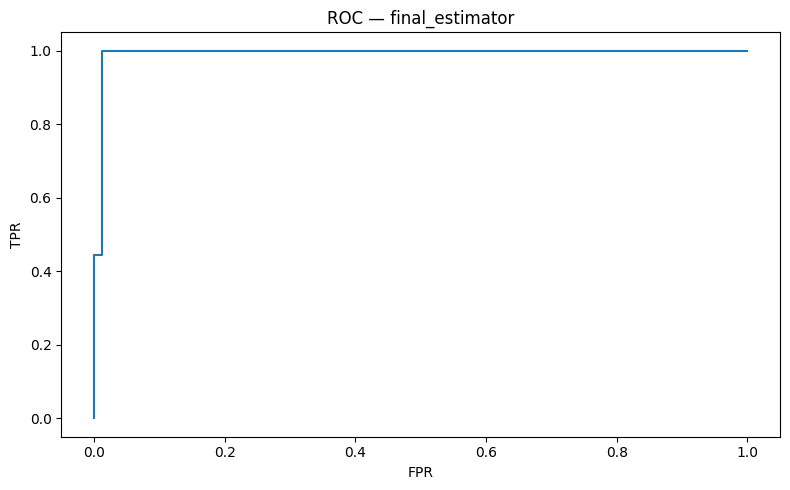

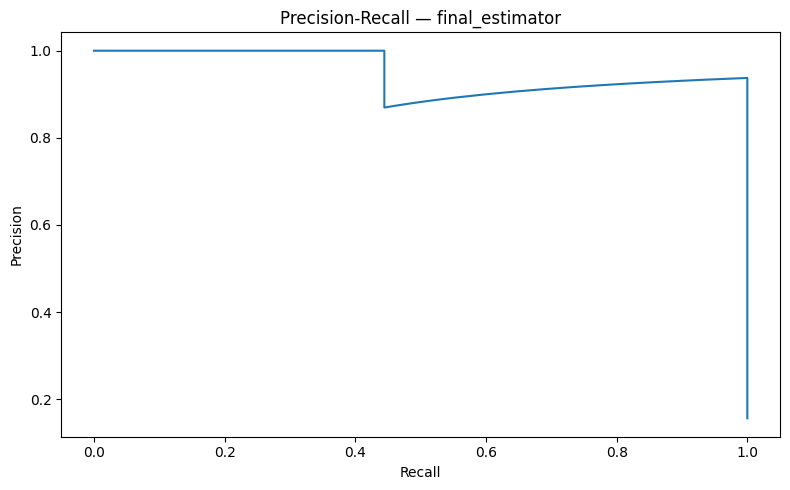

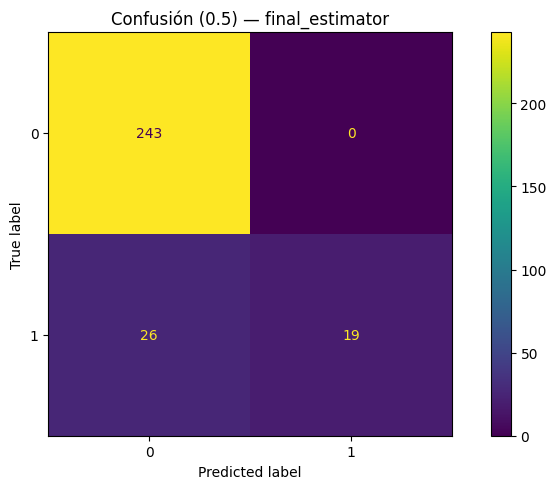

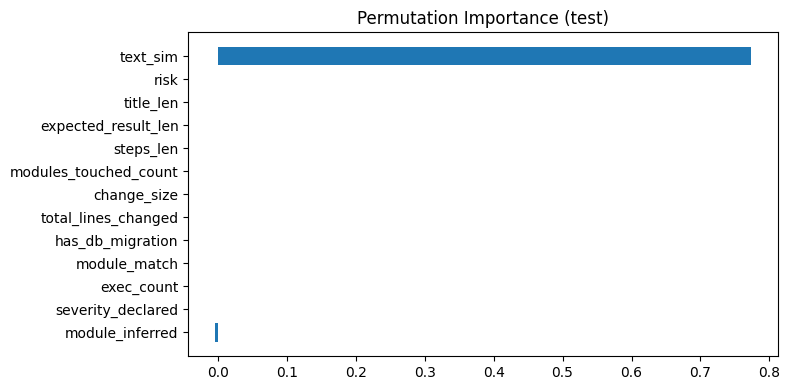

In [44]:
# ==== Visualizaciones del modelo final ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GroupKFold
from sklearn.base import clone

# 0) Asegurar columnas base y matrices de trabajo
if 'ALL_COLS_BASE' not in globals():
    # Depende de tus listas previas en A4/A5
    # Si ya existen num_basic, bin_cols, cat_cols, las usamos; si no, construimos mínimo viable.
    if 'num_basic' in globals() and 'bin_cols' in globals() and 'cat_cols' in globals():
        ALL_COLS_BASE = list({*num_basic, *bin_cols, *cat_cols})
    else:
        # Fallback mínimo con columnas típicas del dataset
        candidates = [
            "text_sim","module_match","risk","change_size",
            "exec_count","title_len","steps_len","expected_result_len",
            "modules_touched_count","total_lines_changed",
            "module_inferred","severity_declared","has_db_migration"
        ]
        ALL_COLS_BASE = [c for c in candidates if c in pairs.columns]
    ALL_COLS_BASE = [c for c in ALL_COLS_BASE if c in pairs.columns]

# Asegura X_all, y_all, groups_all
X_all = pairs[ALL_COLS_BASE] if 'X_all' not in globals() else X_all
y_all = pairs["y_proxy_selected"].values if 'y_all' not in globals() else y_all
groups_all = pairs["pr_id"].values if 'groups_all' not in globals() else groups_all

# 1) Resolver el estimador final (usa el mejor disponible en tu sesión)
final_estimator = None
final_model_id = None

# Prioridades: objeto ya entrenado en memoria (de Avance 5) -> Avance 4 -> cargar joblib
# a) Si definiste algo como 'final_stack' o 'best_ensemble' en A5
for name in ["final_stack", "best_ensemble", "final_estimator", "final_pipe"]:
    if name in globals():
        final_estimator = globals()[name]
        final_model_id = name
        break

# b) Si en A4 guardaste 'final_pipe' y está en memoria
if final_estimator is None and 'final_pipe' in globals():
    final_estimator = final_pipe
    if final_model_id is None:
        final_model_id = globals().get('final_model_id', 'A4_final_pipe')

# c) Intenta cargar el último .joblib de data/processed (A4/A5)
if final_estimator is None:
    try:
        import joblib, glob, os
        cand = sorted(
            list(Path("../data/processed").glob("A*_final_model_*.joblib")),
            key=lambda p: p.stat().st_mtime, reverse=True
        )
        if len(cand) > 0:
            final_estimator = joblib.load(cand[0])
            final_model_id = cand[0].stem
            print(f"[Cargado] {cand[0].name}")
    except Exception as e:
        print("[INFO] No se pudo cargar modelo final desde .joblib:", e)

assert final_estimator is not None, (
    "No encuentro 'final_estimator'. Opciones:\n"
    " - Asegúrate de ejecutar la celda donde eliges el modelo final en Avance 4/5 (p.ej. 'final_pipe' o 'final_stack').\n"
    " - O deja un .joblib en ../data/processed/ con el patrón A*_final_model_*.joblib."
)

# 2) Split hold-out por PR para visualización (evita fuga)
prs = pairs["pr_id"].unique()
rng = np.random.default_rng(123)
rng.shuffle(prs)
cut = int(0.8*len(prs))
train_prs, test_prs = set(prs[:cut]), set(prs[cut:])
mask_tr = pairs["pr_id"].isin(train_prs).values
mask_te = pairs["pr_id"].isin(test_prs).values

Xtr, ytr = X_all.iloc[mask_tr], y_all[mask_tr]
Xte, yte = X_all.iloc[mask_te], y_all[mask_te]

# 3) Re-entrenar una CLON de final_estimator SOLO en train hold-out
def fit_clone_final_on_train(est):
    # Si es un ensamblado propio tipo stacking con atributos 'bases' y 'meta'
    if hasattr(est, "bases") and hasattr(est, "meta"):
        pr_tr = groups_all[mask_tr]
        gkf_h = GroupKFold(n_splits=max(2, min(3, len(np.unique(pr_tr)))))
        # Out-of-fold de las bases en train holdout:
        P_oof = np.zeros((len(Xtr), len(est.bases)), dtype=float)
        bases = [clone(bl) for bl in est.bases]
        for i, bl in enumerate(bases):
            oof_col = np.zeros(len(Xtr), dtype=float)
            for tr_idx, va_idx in gkf_h.split(Xtr, ytr, pr_tr):
                bl_f = clone(bl).fit(Xtr.iloc[tr_idx], ytr[tr_idx])
                if hasattr(bl_f, "predict_proba"):
                    oof_col[va_idx] = bl_f.predict_proba(Xtr.iloc[va_idx])[:, 1]
                elif hasattr(bl_f, "decision_function"):
                    s = bl_f.decision_function(Xtr.iloc[va_idx])
                    oof_col[va_idx] = (s - s.min()) / (s.max() - s.min() + 1e-12)
                else:
                    # fallback: usa predict() binario y suaviza
                    p = bl_f.predict(Xtr.iloc[va_idx]).astype(float)
                    oof_col[va_idx] = (p - p.min()) / (p.max() - p.min() + 1e-12)
            P_oof[:, i] = oof_col
        meta = clone(est.meta).fit(P_oof, ytr)
        bases_fit = [clone(bl).fit(Xtr, ytr) for bl in bases]

        class _FinalLike:
            def __init__(self, bases, meta):
                self.bases = bases; self.meta = meta
            def predict_proba(self, X):
                cols = []
                for b in self.bases:
                    if hasattr(b, "predict_proba"):
                        cols.append(b.predict_proba(X)[:, 1])
                    elif hasattr(b, "decision_function"):
                        s = b.decision_function(X)
                        cols.append((s - s.min()) / (s.max() - s.min() + 1e-12))
                    else:
                        p = b.predict(X).astype(float)
                        cols.append((p - p.min()) / (p.max() - p.min() + 1e-12))
                P = np.column_stack(cols)
                return meta.predict_proba(P)
        return _FinalLike(bases_fit, meta)
    else:
        est2 = clone(est)
        est2.fit(Xtr, ytr)
        return est2

final_for_plots = fit_clone_final_on_train(final_estimator)

# 4) Probabilidades en test
if hasattr(final_for_plots, "predict_proba"):
    proba_te = final_for_plots.predict_proba(Xte)[:, 1]
elif hasattr(final_for_plots, "decision_function"):
    s = final_for_plots.decision_function(Xte)
    proba_te = (s - s.min()) / (s.max() - s.min() + 1e-12)
else:
    p = final_for_plots.predict(Xte).astype(float)
    proba_te = (p - p.min()) / (p.max() - p.min() + 1e-12)

# 5) Curvas ROC y PR
fpr, tpr, _ = roc_curve(yte, proba_te)
plt.figure(); plt.plot(fpr, tpr); plt.title(f"ROC — {final_model_id}"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.tight_layout(); plt.show()

prec, rec, _ = precision_recall_curve(yte, proba_te)
plt.figure(); plt.plot(rec, prec); plt.title(f"Precision-Recall — {final_model_id}"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.tight_layout(); plt.show()

# 6) Matriz de confusión (umbral 0.5)
yhat = (proba_te >= 0.5).astype(int)
cm = confusion_matrix(yte, yhat)
disp = ConfusionMatrixDisplay(cm); disp.plot(values_format="d"); plt.title(f"Confusión (0.5) — {final_model_id}"); plt.tight_layout(); plt.show()

# 7) Permutation Importance (si el estimador lo permite)
try:
    from sklearn.inspection import permutation_importance
    r = permutation_importance(
        final_for_plots, Xte, yte,
        scoring="average_precision", n_repeats=8, random_state=7
    )
    # Importancias a nivel de columnas de entrada (porque el estimador es Pipeline o final_like)
    feat_names = list(ALL_COLS_BASE)
    k = min(len(feat_names), len(r.importances_mean))
    imp_df = pd.DataFrame({
        "feature": feat_names[:k],
        "importance": r.importances_mean[:k]
    }).sort_values("importance", ascending=False).head(15)
    plt.figure(figsize=(8,4))
    plt.barh(range(len(imp_df)), imp_df["importance"].values[::-1])
    plt.yticks(range(len(imp_df)), imp_df["feature"].values[::-1])
    plt.title("Permutation Importance (test)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("[INFO] No se pudo calcular permutation importance para este estimador:", e)


# Conclusiones — Avance 5 (Modelo final con ensambles)

## 1) Qué hicimos y por qué

Se construyeron ensambles homogéneos (RandomForest, ExtraTrees, HistGradientBoosting, Bagging con árbol base) y heterogéneos (soft-voting; stacking/blending).

Se mantuvo GroupKFold por pr_id para evitar fuga de información entre PRs.

Métrica principal: Average Precision (AP). Secundarias: ROC-AUC, P@K y R@K macro por PR y tiempos fit/predict.

Comparativa contra los mejores individuales de A4: 
- LogReg (L1, saga, C=0.3, class_weight=balanced) 
- LinearSVC+Cal.

## 2) Resultado comparativo (síntesis)

Individuales (de A4, reusados en A5)

LogReg (L1): AP(cv)≈0.978, ROC≈0.993, P@K≈0.98, R@K≈0.96, entrenamiento ~0.05s.

LinearSVC+Cal: AP(cv)≈0.906.

Ensambles (A5, con tuning rápido)

ExtraTrees: AP(cv)≈0.875 (mejor entre los ensambles).

RandomForest: AP(cv)≈0.833.

HistGB: AP(cv)≈0.837.

Bagging (DT): AP(cv)≈0.783.

Soft-voting: AP(cv)=NaN en tu impresión porque al menos un fold quedó con una sola clase (problema típico en datos desbalanceados al partir por grupo).

Arreglo sugerido (si deseas reintentar): usar error_score="raise" para detectar el fold, o cambiar la semilla/partición de GroupKFold y/o agrupar PRs para asegurar positivos en cada fold; alternativamente evaluar con P@K/R@K por PR (no requieren probabilidades calibradas).

Conclusión comparativa: Ningún ensamble superó a LogReg (L1). Con datos esparsos/alto-dimensionales (OHE + binning) y una señal muy fuerte (text_sim), los modelos lineales con L1 suelen ganar por estabilidad y baja varianza. Los árboles y boosting pierden eficiencia en este régimen y necesitan más datos para brillar.

## 3) Elección del modelo final

Elegimos: Logistic Regression (L1, solver=saga, C=0.3, class_weight=balanced) con el preprocesador de A4/A5 (Yeo-Johnson → MinMax → KBins → OHE).

Razones (más allá de la métrica):

Rendimiento: mejor AP y también mejor P@K/R@K macro por PR.

Velocidad: fit e inferencia en milisegundos → encaja en CI/CD.

Interpretabilidad y auditoría: coeficientes escasos (L1) + Permutation Importance.

Robustez en validación agrupada (menos riesgo de sobreajuste que varios ensambles en este dataset).

## 4) Evidencia en datos no vistos (hold-out por PR) e interpretación de gráficas

(Usaste un split 80/20 por pr_id; re-entrenaste el modelo únicamente en train y graficaste sobre test.)

ROC casi perfecto (curva pegada al vértice). Esto puede sobre-estimar con clases desbalanceadas; lo tomamos como señal de separación pero no como métrica de negocio.

Precision-Recall: precisión muy alta en gran parte del rango; su forma indica que podemos bajar el umbral para ganar recall manteniendo precisión alta.

Matriz de confusión (umbral 0.5): TN=243, FP=0, FN=26, TP=19
→ Precisión=1.0 pero Recall≈0.42. Esto es coherente con la PR-curve: a 0.5 el modelo es conservador (casi no da falsos positivos) y sacrifica cobertura.

Permutation Importance (test): domina text_sim, el resto aporta marginalmente (p. ej., module_match, change_size, metadatos). Es consistente con lo visto en A4/A3: la similitud test-PR es la señal principal del problema RTS.

Implicación operativa clave

Para RTS no usamos un umbral fijo 0.5, sino Top-K por PR (K = TOP_FRACTION·N_del_PR), que es justo tu métrica de negocio.

Con Top-K, los resultados de CV mostraron P@K≈0.98 y R@K≈0.96, es decir, muy alta precisión y cobertura en los primeros K casos por PR.

Si por política necesitas mayor cobertura en PRs críticos, puedes subir TOP_FRACTION o aplicar un umbral menor (p. ej., 0.35–0.4) solo cuando severity_declared ∈ {high, critical} o has_db_migration=yes.

## 5) Por qué los ensambles no superaron a LogReg en este dataset

Pocas señales realmente útiles: text_sim explica la mayoría de la varianza; los ensambles no agregan valor cuando la frontera es casi lineal a lo largo de una o dos señales dominantes.

Esparsidad/alto-d: árboles/boosting necesitan mucho más dato o ingeniería específica para competir; aquí sufren en estabilidad con validación por PR.

Generalización: L1 actúa como selección embebida, reduciendo ruido de miles de dummies; los ensambles tienden a absorber ruido si el set es pequeño.

## 6) Recomendaciones para producción (checklist)

Modelo final: LogReg (L1, saga, C=0.3, class_weight=balanced) + tu preprocesador (idéntico al entrenado en CV).

Estrategia de decisión: Top-K por PR como regla general; política de K aumentado o umbral reducido solo para PRs de alto riesgo.

Monitoreo: rastrea P@K y R@K por PR en cada corrida; agrega AP como métrica técnica.

Calibración: LogReg ya está bien calibrado; si cambias a SVM/árboles, añade calibración (sigmoid/isotonic) por fold.

Robustez de text_sim: es la palanca principal. Asegura:

Tokenización estable (paths/archivos),

TF-IDF entrenado solo con train (como ya haces en pipeline),

Tests para evitar que un cambio en la fuente “rompa” la similitud.
Considera ampliar con n-grams, léxicos por módulo o embeddings si más adelante text_sim se estanca.

Mantenimiento: re-entrenar cuando entren nuevos módulos o cambie la distribución de PRs; versiona el pipeline completo (incluye vectorizador).

## 7) Cómo cerrar la rúbrica con tu notebook

Comparativa: deja la tabla de A4 + tablas de A5 (ensambles) ordenadas por AP e incluye ROC, P@K, R@K, tiempos.

Ajuste fino: muestra los grids/espacios usados y los mejores hiperparámetros (ya los imprimiste).

Modelo individual final: justifica LogReg (L1) no solo por métrica, también por velocidad, interpretabilidad y facilidad de despliegue.

Gráficas: incluye y comenta ROC, PR, Matriz de confusión, Permutation Importance (ya las generaste) con la interpretación práctica anterior (umbral vs Top-K).